In [206]:
# Technical Indicators
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
from ta.volatility import KeltnerChannel
from ta.momentum import ROCIndicator

# Plotting
import matplotlib.pyplot as plt

# Getting data
import yfinance as yf
import math
import pandas as pd
import numpy as np


In [207]:
stocks = ['META','AMZN', 'AAPL', 'NFLX', 'GOOGL']
weight = 1/len(stocks)

start = '2015-01-01'
end = '2019-12-31'

data = yf.download(stocks, start=start, end=end, progress=False)['Close']
data.index = data.index.date

data

Ticker           AAPL       AMZN      GOOGL        META        NFLX
2015-01-02  27.332500  15.426000  26.477501   78.449997   49.848572
2015-01-05  26.562500  15.109500  25.973000   77.190002   47.311428
2015-01-06  26.565001  14.764500  25.332001   76.150002   46.501431
2015-01-07  26.937500  14.921000  25.257500   76.150002   46.742859
2015-01-08  27.972500  15.023000  25.345501   78.180000   47.779999
...               ...        ...        ...         ...         ...
2019-12-23  71.000000  89.650002  67.531502  206.179993  333.100006
2019-12-24  71.067497  89.460503  67.221497  205.119995  333.200012
2019-12-26  72.477501  93.438499  68.123497  207.789993  332.630005
2019-12-27  72.449997  93.489998  67.732002  208.100006  329.089996
2019-12-30  72.879997  92.344498  66.985497  204.410004  323.309998

[1257 rows x 5 columns]

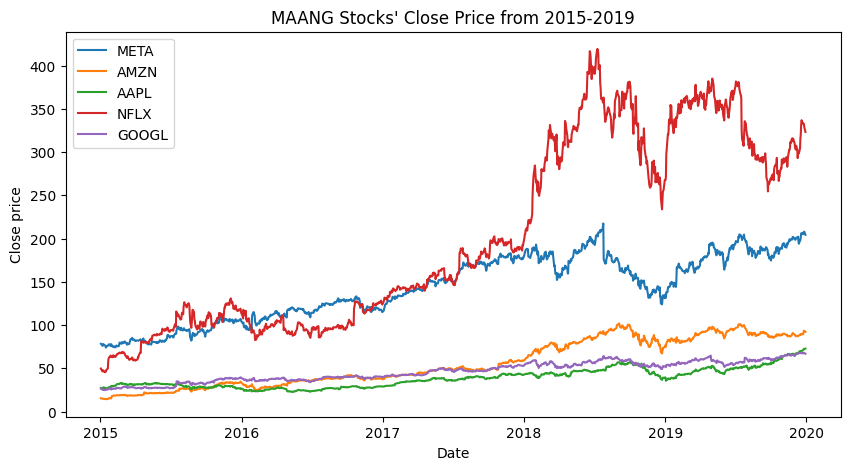

In [208]:
# Plot close price for each stock from 2015-2019

fig = plt.figure(figsize=(10, 5))

for stock in stocks:
    plt.plot(data.index, data[stock], label=stock)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Close price')
plt.title(f'MAANG Stocks\' Close Price from 2015-2019')
plt.show()

**Momentum Strategy: MACD + EMA(200)**

*MACD indicator computation: MACD = EMA(12) - EMA(26) and MACD signal line = EMA(9) of MACD line*

Buy signal:
- MACD crosses above signal line, AND
- Stock price crosses above EMA(200)

Sell signal:
- MACD crosses below signal line, AND
- Stock price crosses below EMA(200)

In [209]:
def conditionGenerator(ema, macd, signal_line, prev_position, close_price):
    """Generate signals based on EMA 200 and MACD logic."""
    
    ## Long -- Price > EMA 200 and MACD crosses above signal line
    if (close_price > ema) and (macd > signal_line) and (prev_position != 1):
        return 1  # Long position
    
    ## Short -- Price < EMA 200 and MACD crosses below signal line
    elif (close_price < ema) and (macd < signal_line) and (prev_position != -1):
        return -1  # Short position

    ## Otherwise, maintain previous position
    else:
        return prev_position  # Hold current position


In [210]:
import pandas as pd

def strategy(stock, ema_window, macd_fast, macd_slow, macd_signal):
    """
    Calculate the EMA and MACD indicators, and generate buy/sell signals for a given stock.
    
    Parameters:
    - stock: The stock symbol
    - ema_window: The window for the long-term EMA
    - macd_fast: The fast EMA window for MACD
    - macd_slow: The slow EMA window for MACD 
    - macd_signal: The signal line window for MACD 
    """
    
    # Create a DataFrame for the stock data
    strat = pd.DataFrame(index=data.index)
    strat[f'{stock}_Close'] = yf.download(stock, start=start, end=end, progress=False)['Close']

    # Calculate long-term EMA 
    strat[f'{stock}_EMA'] = strat[f'{stock}_Close'].ewm(span=ema_window, adjust=False).mean()

    # Calculate MACD (using the fast and slow EMAs)
    exp_fast = strat[f'{stock}_Close'].ewm(span=macd_fast, adjust=False).mean()
    exp_slow = strat[f'{stock}_Close'].ewm(span=macd_slow, adjust=False).mean()
    strat[f'{stock}_MACD'] = exp_fast - exp_slow
    
    # Calculate MACD Signal Line
    strat[f'{stock}_Signal_Line'] = strat[f'{stock}_MACD'].ewm(span=macd_signal, adjust=False).mean()

    # Initialize position column
    strat[f'{stock}_Position'] = 0  # 1 for long, -1 for short

    # Generate signals using a loop
    for i in range(1, len(strat)):
        T_minus_one = strat.index[i - 1]
        T_day = strat.index[i]

        # Long signal: Price > EMA and MACD crosses above signal line
        if (strat.loc[T_day, f'{stock}_Close'] > strat.loc[T_day, f'{stock}_EMA']) and \
           (strat.loc[T_day, f'{stock}_MACD'] > strat.loc[T_day, f'{stock}_Signal_Line']) and \
           (strat.loc[T_minus_one, f'{stock}_MACD'] <= strat.loc[T_minus_one, f'{stock}_Signal_Line']):
            strat.loc[T_day, f'{stock}_Position'] = 1  # Long signal

        # Short signal: Price < EMA and MACD crosses below signal line
        elif (strat.loc[T_day, f'{stock}_Close'] < strat.loc[T_day, f'{stock}_EMA']) and \
             (strat.loc[T_day, f'{stock}_MACD'] < strat.loc[T_day, f'{stock}_Signal_Line']) and \
             (strat.loc[T_minus_one, f'{stock}_MACD'] >= strat.loc[T_minus_one, f'{stock}_Signal_Line']):
            strat.loc[T_day, f'{stock}_Position'] = -1  # Short signal

        # Otherwise, hold the previous day's position
        else:
            strat.loc[T_day, f'{stock}_Position'] = strat.loc[T_minus_one, f'{stock}_Position']

    return strat

In [211]:
# Run the strategy for each MAANG stock
stockList = {'META': {}, 'AAPL': {}, 'AMZN': {}, 'NFLX': {}, 'GOOGL': {}}

for stock in stockList:
    stockList[stock]['params'] = {'ema_window': 200, 'macd_params': (12, 26, 9)}
    ema_window = stockList[stock]['params']['ema_window']
    macd_params = stockList[stock]['params']['macd_params'] 
    macd_fast, macd_slow, macd_signal = macd_params
    stockList[stock]['strat'] = strategy(stock, ema_window, macd_fast, macd_slow, macd_signal)


In [212]:
# Accessing the strategy for META
meta_strategy = stockList['META']['strat']
meta_strategy

META_Close    META_EMA  META_MACD  META_Signal_Line  META_Position
2015-01-02   78.449997   78.449997   0.000000          0.000000              0
2015-01-05   77.190002   78.437460  -0.100512         -0.020102             -1
2015-01-06   76.150002   78.414699  -0.261079         -0.068298             -1
2015-01-07   76.150002   78.392165  -0.383904         -0.131419             -1
2015-01-08   78.180000   78.390054  -0.313822         -0.167900             -1
...                ...         ...        ...               ...            ...
2019-12-23  206.179993  186.006692   2.527639          2.116499              1
2019-12-24  205.119995  186.196874   2.595922          2.212383              1
2019-12-26  207.789993  186.411731   2.832828          2.336472              1
2019-12-27  208.100006  186.627534   3.010885          2.471355              1
2019-12-30  204.410004  186.804474   2.821718          2.541427              1

[1257 rows x 5 columns]

In [213]:
# Accessing the strategy for AAPL
aapl_strategy = stockList['AAPL']['strat']
aapl_strategy

AAPL_Close   AAPL_EMA  AAPL_MACD  AAPL_Signal_Line  AAPL_Position
2015-01-02   27.332500  27.332500   0.000000          0.000000              0
2015-01-05   26.562500  27.324839  -0.061425         -0.012285             -1
2015-01-06   26.565001  27.317278  -0.108650         -0.031558             -1
2015-01-07   26.937500  27.313499  -0.114696         -0.048186             -1
2015-01-08   27.972500  27.320057  -0.035562         -0.045661              1
...                ...        ...        ...               ...            ...
2019-12-23   71.000000  56.152818   1.616619          1.462688              1
2019-12-24   71.067497  56.301223   1.656653          1.501481              1
2019-12-26   72.477501  56.462181   1.781618          1.557508              1
2019-12-27   72.449997  56.621264   1.857027          1.617412              1
2019-12-30   72.879997  56.783042   1.929248          1.679779              1

[1257 rows x 5 columns]

In [214]:
# Accessing the strategy for AMZN
amzn_strategy = stockList['AMZN']['strat']
amzn_strategy

AMZN_Close   AMZN_EMA  AMZN_MACD  AMZN_Signal_Line  AMZN_Position
2015-01-02   15.426000  15.426000   0.000000          0.000000              0
2015-01-05   15.109500  15.422850  -0.025248         -0.005050             -1
2015-01-06   14.764500  15.416300  -0.072263         -0.018492             -1
2015-01-07   14.921000  15.411371  -0.095790         -0.033952             -1
2015-01-08   15.023000  15.407507  -0.104994         -0.048160             -1
...                ...        ...        ...               ...            ...
2019-12-23   89.650002  89.058414   0.254335          0.053648              1
2019-12-24   89.460503  89.062415   0.284445          0.099808              1
2019-12-26   93.438499  89.105958   0.622128          0.204272              1
2019-12-27   93.489998  89.149580   0.883712          0.340160              1
2019-12-30   92.344498  89.181371   0.987207          0.469569              1

[1257 rows x 5 columns]

In [215]:
# Accessing the strategy for NFLX
nflx_strategy = stockList['NFLX']['strat']
nflx_strategy

NFLX_Close    NFLX_EMA  NFLX_MACD  NFLX_Signal_Line  NFLX_Position
2015-01-02   49.848572   49.848572   0.000000          0.000000              0
2015-01-05   47.311428   49.823327  -0.202393         -0.040479             -1
2015-01-06   46.501431   49.790273  -0.423272         -0.117037             -1
2015-01-07   46.742859   49.759950  -0.572243         -0.208078             -1
2015-01-08   47.779999   49.740249  -0.599701         -0.286403             -1
...                ...         ...        ...               ...            ...
2019-12-23  333.100006  312.562129   8.188670          5.255982              1
2019-12-24  333.200012  312.767482   8.832670          5.971319              1
2019-12-26  332.630005  312.965119   9.191100          6.615276              1
2019-12-27  329.089996  313.125565   9.084785          7.109178              1
2019-12-30  323.309998  313.226903   8.436878          7.374718              1

[1257 rows x 5 columns]

In [216]:
# Accessing the strategy for NFLX
nflx_strategy = stockList['NFLX']['strat']
nflx_strategy

NFLX_Close    NFLX_EMA  NFLX_MACD  NFLX_Signal_Line  NFLX_Position
2015-01-02   49.848572   49.848572   0.000000          0.000000              0
2015-01-05   47.311428   49.823327  -0.202393         -0.040479             -1
2015-01-06   46.501431   49.790273  -0.423272         -0.117037             -1
2015-01-07   46.742859   49.759950  -0.572243         -0.208078             -1
2015-01-08   47.779999   49.740249  -0.599701         -0.286403             -1
...                ...         ...        ...               ...            ...
2019-12-23  333.100006  312.562129   8.188670          5.255982              1
2019-12-24  333.200012  312.767482   8.832670          5.971319              1
2019-12-26  332.630005  312.965119   9.191100          6.615276              1
2019-12-27  329.089996  313.125565   9.084785          7.109178              1
2019-12-30  323.309998  313.226903   8.436878          7.374718              1

[1257 rows x 5 columns]

In [217]:
def visualize_signals(stock, strat, ema_window, macd_fast, macd_slow):
    """Plot 2 stacked graphs for the provided stock: 
    1. Close price with specified EMA, 
    2. MACD with Signal Line.
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharex=True, 
                                    gridspec_kw={'height_ratios': [3, 1]})

    # Stock price and EMA
    ax1.set_title(f'{stock} Close Price with {ema_window}-day EMA and Buy/Sell Signals')
    ax1.plot(strat[f'{stock}_Close'], label=f'{stock} Close Price', color='black', alpha=0.5)
    ax1.plot(strat[f'{stock}_EMA'], label=f'{stock} {ema_window}-day EMA', color='blue')

    # Plot buy and sell signals on price graph
    buy_signals = strat[(strat[f'{stock}_Position'] == 1) & (strat[f'{stock}_Position'].shift(1) != 1)]
    ax1.scatter(buy_signals.index, buy_signals[f'{stock}_Close'], marker='^', color='g', label='Buy Signal', s=100)

    sell_signals = strat[(strat[f'{stock}_Position'] == -1) & (strat[f'{stock}_Position'].shift(1) != -1)]
    ax1.scatter(sell_signals.index, sell_signals[f'{stock}_Close'], marker='v', color='r', label='Sell Signal', s=100)

    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # MACD and Signal Line
    ax2.set_title(f'{stock} MACD and Signal Line (Fast: {macd_fast}, Slow: {macd_slow})')
    ax2.plot(strat[f'{stock}_MACD'], label=f'{stock} MACD Line', color='green')
    ax2.plot(strat[f'{stock}_Signal_Line'], label=f'{stock} Signal Line', color='red')

    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD/Signal Line')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


def plot_long_short_pos(stock, strat):
    """Plot long/short positions."""
    
    plt.figure(figsize=(15, 2))
    plt.plot(strat.index, strat[f'{stock}_Position'], label=f'{stock} Position', color='purple', alpha=0.7)
    
    plt.title(f'{stock} Long/Short Positions')
    plt.xlabel('Date')
    plt.ylabel('Position')
    plt.grid(True)
    plt.show()


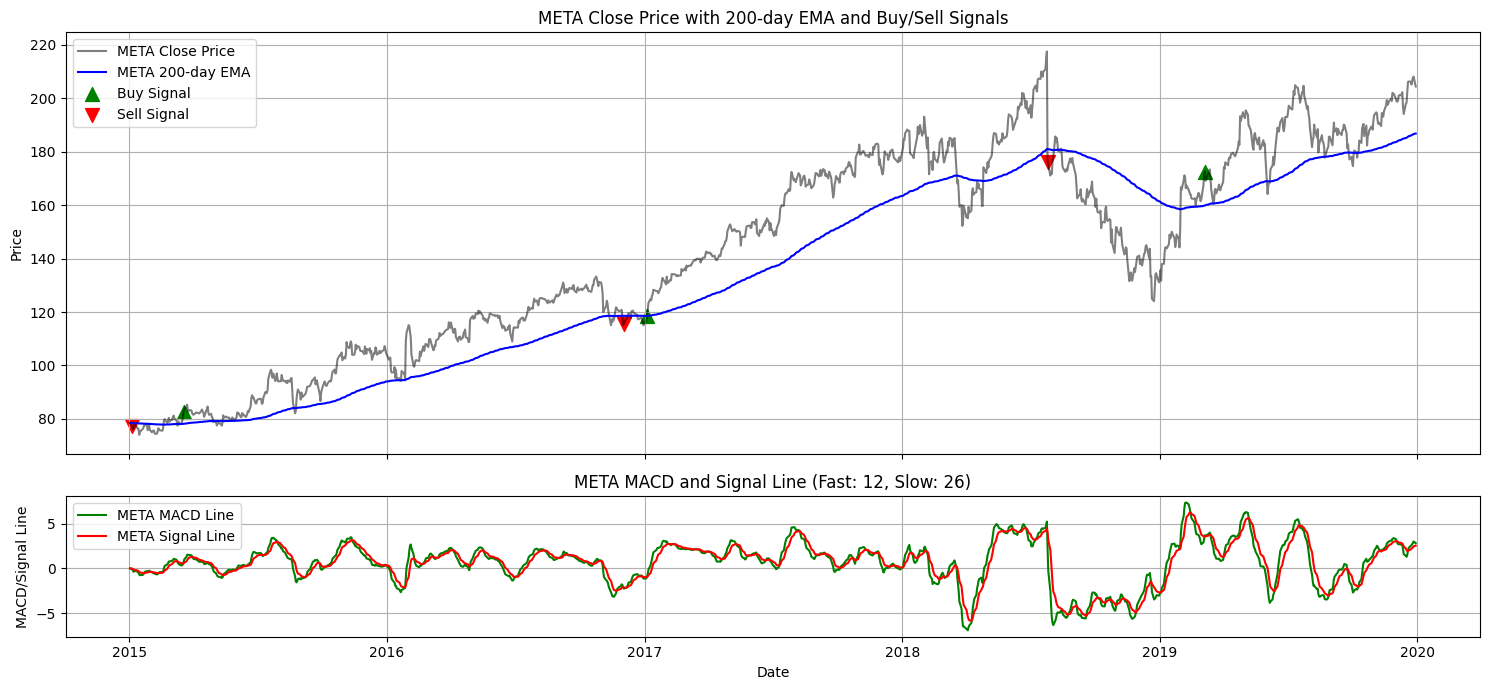

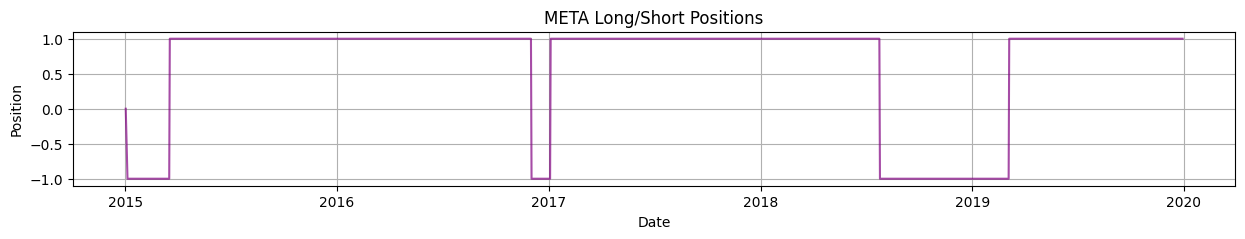

In [218]:
# For META
stock = 'META'
strat = stockList[stock]['strat']
ema_window = stockList[stock]['params']['ema_window']
macd_params = stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

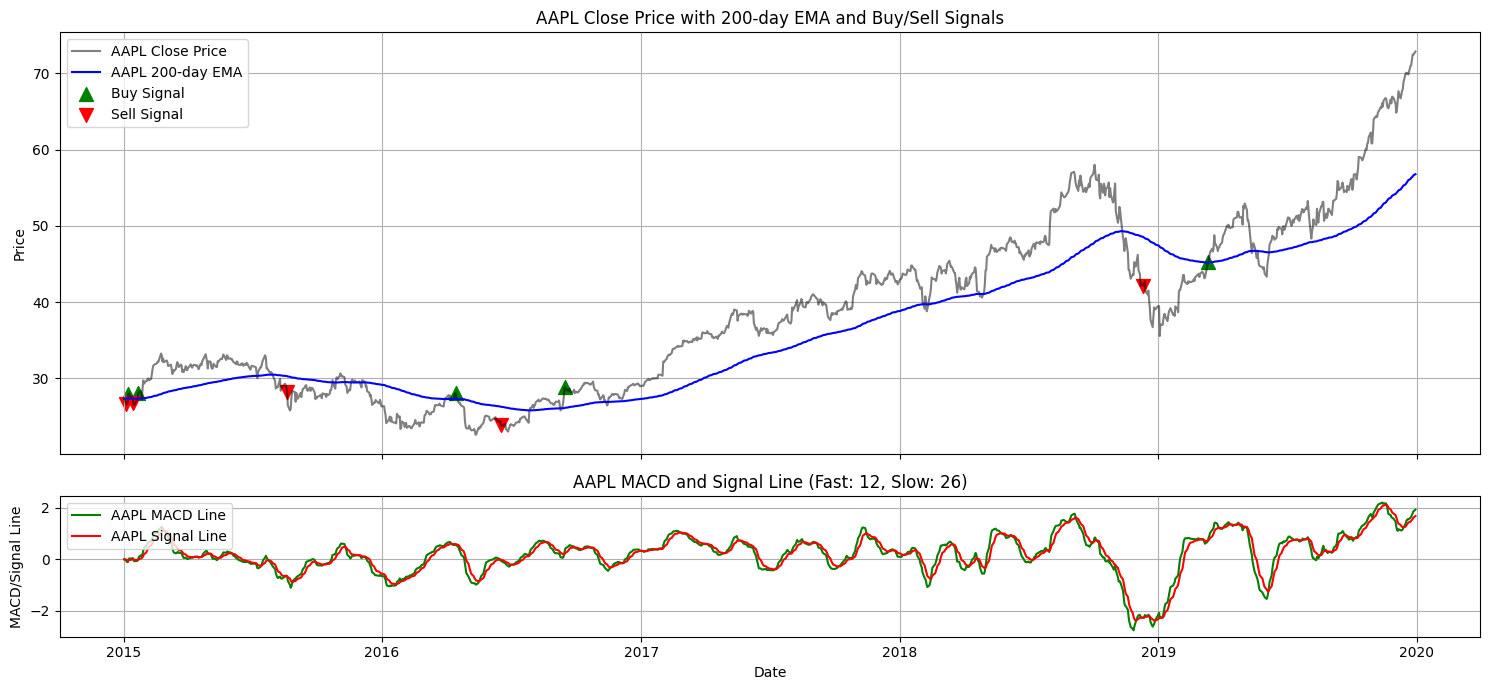

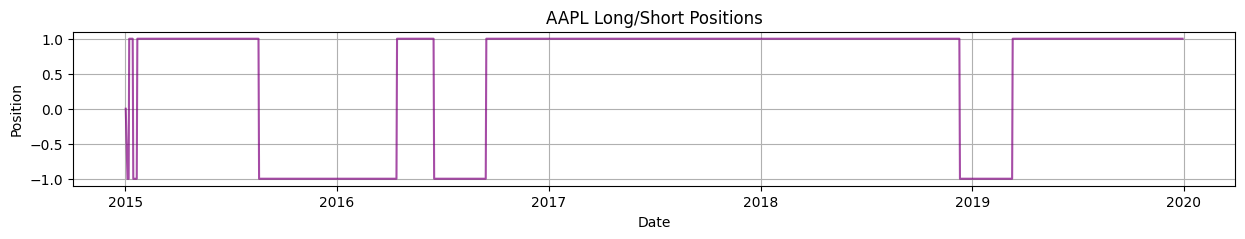

In [219]:
# For AAPL
stock = 'AAPL'
strat = stockList[stock]['strat']
ema_window = stockList[stock]['params']['ema_window']
macd_params = stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

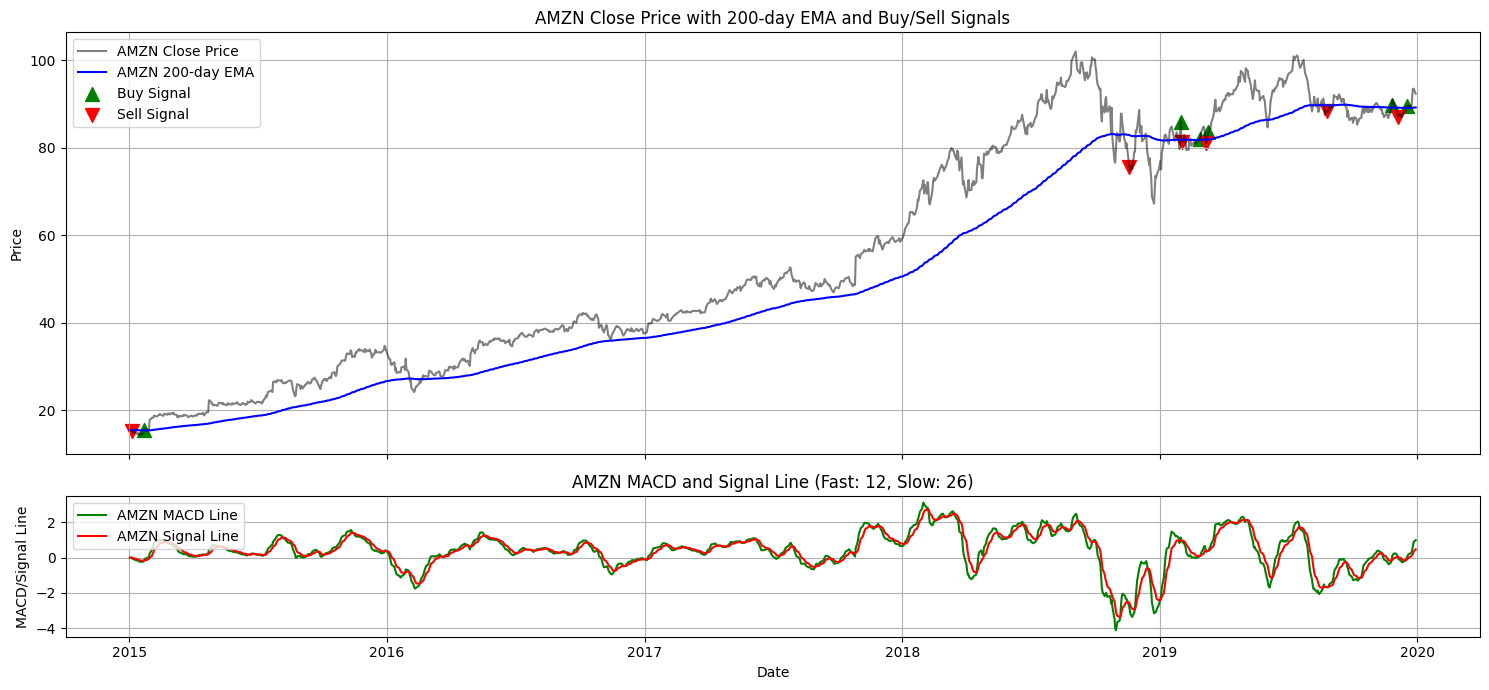

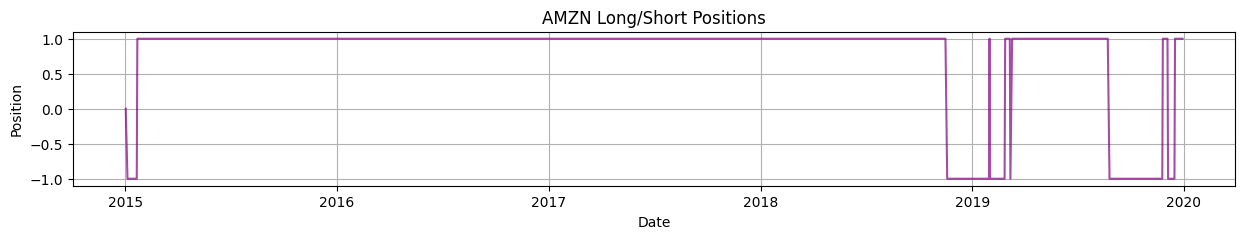

In [220]:
# For AMZN
stock = 'AMZN'
strat = stockList[stock]['strat']
ema_window = stockList[stock]['params']['ema_window']
macd_params = stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

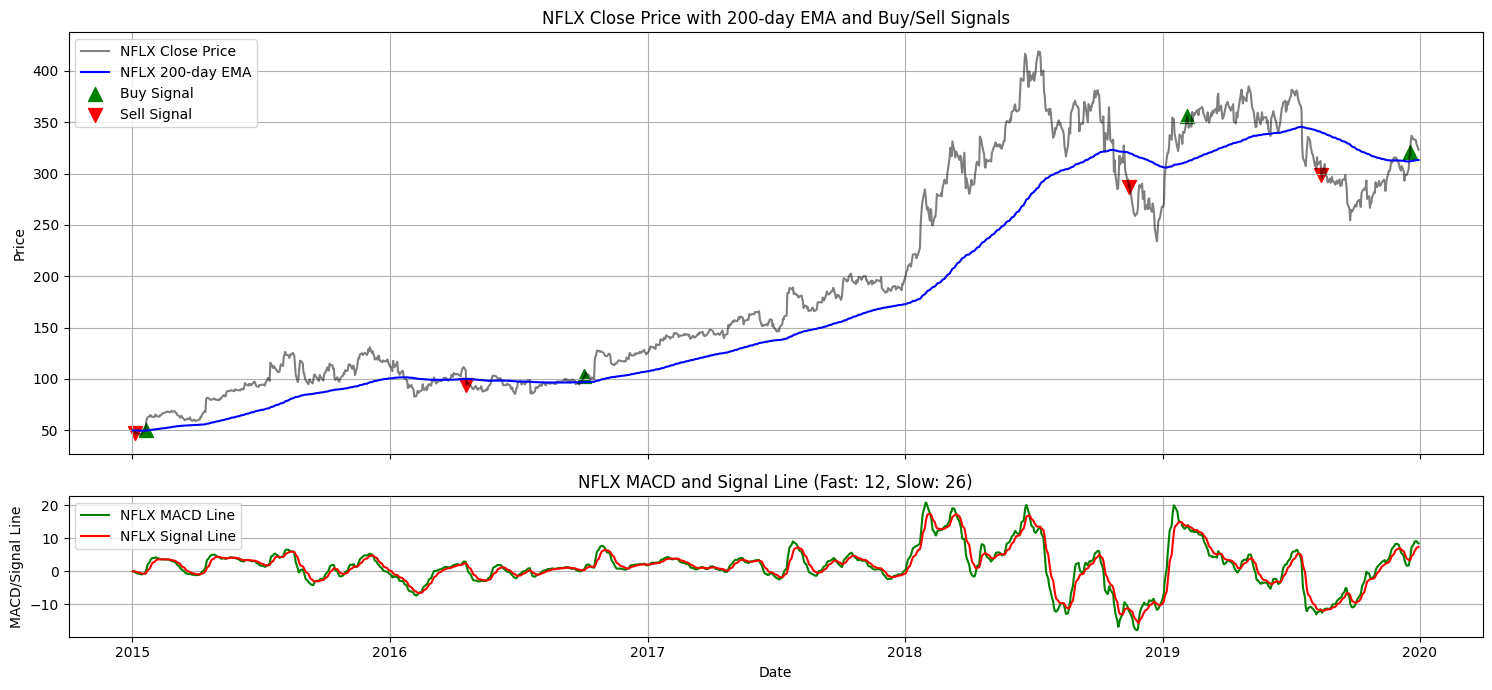

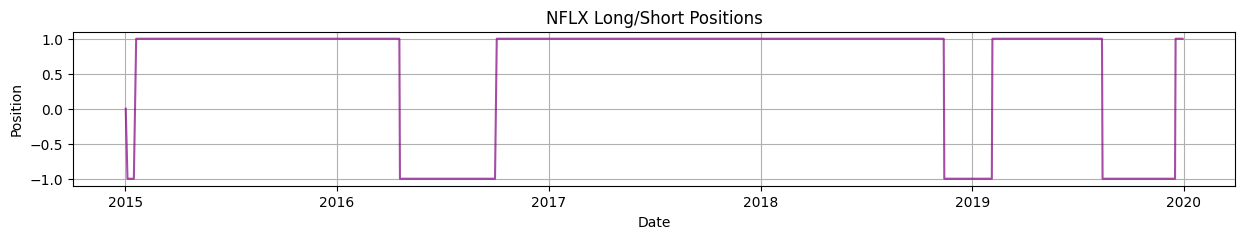

In [221]:
# For NFLX
stock = 'NFLX'
strat = stockList[stock]['strat']
ema_window = stockList[stock]['params']['ema_window']
macd_params = stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

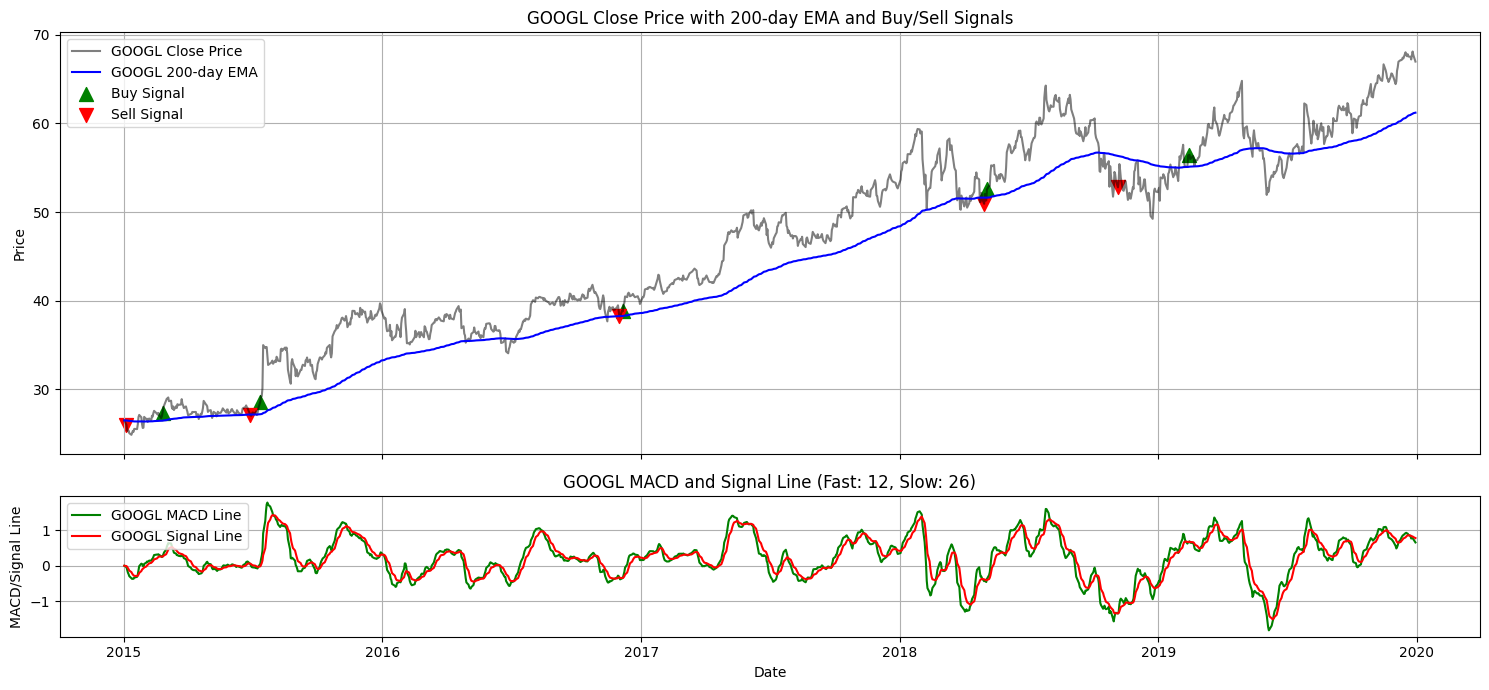

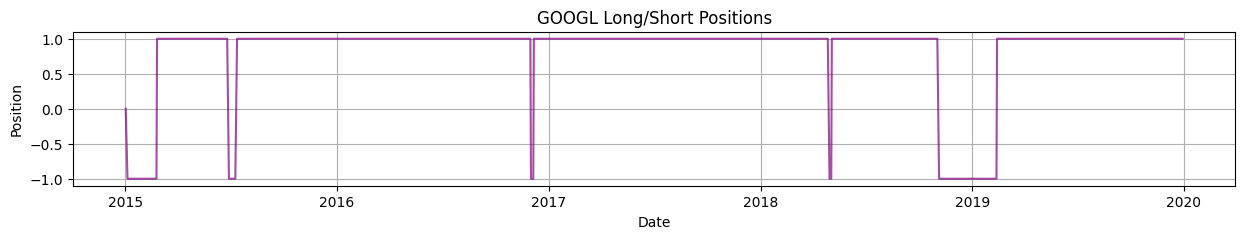

In [222]:
# For GOOGL
stock = 'GOOGL'
strat = stockList[stock]['strat']
ema_window = stockList[stock]['params']['ema_window']
macd_params = stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

In [223]:
def calculate_log_returns(stocks, tuned_stockList):
    """Calculate log stock, strategy, and benchmark returns for each stock and combined benchmark."""
    
    # Initialize arrays for benchmark and equal-weighted strategy returns
    benchmark_regular_returns = np.zeros(len(tuned_stockList[stocks[0]]['strat'])) 
    equal_weighted_regular_returns = np.zeros(len(tuned_stockList[stocks[0]]['strat']))
    
    # Loop through each stock and calculate the log returns
    for stock in stocks:
        stock_data = tuned_stockList[stock]['strat']  # Get the DataFrame for the current stock

        # Calculate log stock returns
        stock_regular_returns = stock_data[f'{stock}_Close'].pct_change()
        stock_data[f'{stock}_Log_Returns'] = np.log(1 + stock_regular_returns)
        
        # Calculate log strategy returns
        strategy_regular_returns = stock_regular_returns * stock_data[f'{stock}_Position'].shift(1)
        stock_data[f'{stock}_Strategy_Log_Returns'] = np.log(1 + strategy_regular_returns)

        # Add stock returns to benchmark and equal-weighted strategy
        benchmark_regular_returns += stock_regular_returns / len(stocks)
        equal_weighted_regular_returns += strategy_regular_returns / len(stocks)

    # Add the benchmark log returns and equal-weighted strategy log returns to each stock's DataFrame
    for stock in stocks:
        stock_data = tuned_stockList[stock]['strat']
        stock_data['Benchmark_Log_Returns'] = np.log(1 + benchmark_regular_returns)
        stock_data['Equal_Weighted_Strategy_Log_Returns'] = np.log(1 + equal_weighted_regular_returns)

    return tuned_stockList


In [224]:
# Call the function to calculate log returns for each stock
stockList = calculate_log_returns(stocks, stockList)

# Output the head of each stock's DataFrame
for stock in stocks:
    print(f"Head of {stock} DataFrame:")
    display(stockList[stock]['strat'].head())  # Display the first few rows of each stock's data

Head of META DataFrame:


META_Close   META_EMA  META_MACD  META_Signal_Line  META_Position  \
2015-01-02   78.449997  78.449997   0.000000          0.000000              0   
2015-01-05   77.190002  78.437460  -0.100512         -0.020102             -1   
2015-01-06   76.150002  78.414699  -0.261079         -0.068298             -1   
2015-01-07   76.150002  78.392165  -0.383904         -0.131419             -1   
2015-01-08   78.180000  78.390054  -0.313822         -0.167900             -1   

            META_Log_Returns  META_Strategy_Log_Returns  \
2015-01-02               NaN                        NaN   
2015-01-05         -0.016191                   0.000000   
2015-01-06         -0.013565                   0.013383   
2015-01-07          0.000000                   0.000000   
2015-01-08          0.026309                  -0.027020   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

Head of AMZN DataFrame:


AMZN_Close   AMZN_EMA  AMZN_MACD  AMZN_Signal_Line  AMZN_Position  \
2015-01-02     15.4260  15.426000   0.000000          0.000000              0   
2015-01-05     15.1095  15.422850  -0.025248         -0.005050             -1   
2015-01-06     14.7645  15.416300  -0.072263         -0.018492             -1   
2015-01-07     14.9210  15.411371  -0.095790         -0.033952             -1   
2015-01-08     15.0230  15.407507  -0.104994         -0.048160             -1   

            AMZN_Log_Returns  AMZN_Strategy_Log_Returns  \
2015-01-02               NaN                        NaN   
2015-01-05         -0.020731                   0.000000   
2015-01-06         -0.023098                   0.022577   
2015-01-07          0.010544                  -0.010656   
2015-01-08          0.006813                  -0.006859   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

Head of AAPL DataFrame:


AAPL_Close   AAPL_EMA  AAPL_MACD  AAPL_Signal_Line  AAPL_Position  \
2015-01-02   27.332500  27.332500   0.000000          0.000000              0   
2015-01-05   26.562500  27.324839  -0.061425         -0.012285             -1   
2015-01-06   26.565001  27.317278  -0.108650         -0.031558             -1   
2015-01-07   26.937500  27.313499  -0.114696         -0.048186             -1   
2015-01-08   27.972500  27.320057  -0.035562         -0.045661              1   

            AAPL_Log_Returns  AAPL_Strategy_Log_Returns  \
2015-01-02               NaN                        NaN   
2015-01-05         -0.028576                   0.000000   
2015-01-06          0.000094                  -0.000094   
2015-01-07          0.013925                  -0.014121   
2015-01-08          0.037703                  -0.039180   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

Head of NFLX DataFrame:


NFLX_Close   NFLX_EMA  NFLX_MACD  NFLX_Signal_Line  NFLX_Position  \
2015-01-02   49.848572  49.848572   0.000000          0.000000              0   
2015-01-05   47.311428  49.823327  -0.202393         -0.040479             -1   
2015-01-06   46.501431  49.790273  -0.423272         -0.117037             -1   
2015-01-07   46.742859  49.759950  -0.572243         -0.208078             -1   
2015-01-08   47.779999  49.740249  -0.599701         -0.286403             -1   

            NFLX_Log_Returns  NFLX_Strategy_Log_Returns  \
2015-01-02               NaN                        NaN   
2015-01-05         -0.052238                   0.000000   
2015-01-06         -0.017269                   0.016976   
2015-01-07          0.005178                  -0.005205   
2015-01-08          0.021946                  -0.022438   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

Head of GOOGL DataFrame:


GOOGL_Close  GOOGL_EMA  GOOGL_MACD  GOOGL_Signal_Line  \
2015-01-02    26.477501  26.477501    0.000000           0.000000   
2015-01-05    25.973000  26.472481   -0.040245          -0.008049   
2015-01-06    25.332001  26.461133   -0.122451          -0.030929   
2015-01-07    25.257500  26.449156   -0.191406          -0.063025   
2015-01-08    25.345501  26.438175   -0.236228          -0.097665   

            GOOGL_Position  GOOGL_Log_Returns  GOOGL_Strategy_Log_Returns  \
2015-01-02               0                NaN                         NaN   
2015-01-05              -1          -0.019238                    0.000000   
2015-01-06              -1          -0.024989                    0.024380   
2015-01-07              -1          -0.002945                    0.002937   
2015-01-08              -1           0.003478                   -0.003490   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

In [225]:
### Compute the stock and strategy gross performance/returns for all 5 individual stocks and equal-weighted strategy

def calculate_gross_regular_returns(stock_or_strategy, strat, is_equal_weighted=False):
    """Calculate gross regular returns for individual stock strategies and equal-weighted strategy and benchmark."""
    
    if is_equal_weighted:
        # Calculate for equal-weighted strategy
        cumulative_strategy_log_return = strat['Equal_Weighted_Strategy_Log_Returns'].sum()
        strategy_label = "Equal-Weighted Strategy"
        
    else:
        # Calculate for individual stock
        cumulative_strategy_log_return = strat[f'{stock_or_strategy}_Strategy_Log_Returns'].sum()
        cumulative_stock_log_return = strat[f'{stock_or_strategy}_Log_Returns'].sum()
        gross_stock_return = np.exp(cumulative_stock_log_return) - 1
        print(f'{stock_or_strategy} Gross Stock Performance: {gross_stock_return:.4f}')
        strategy_label = f'{stock_or_strategy} Strategy'
    
    # Calculate cumulative benchmark log returns
    cumulative_benchmark_log_return = strat['Benchmark_Log_Returns'].sum()
    
    # Convert cumulative log returns to gross regular returns
    gross_strategy_return = np.exp(cumulative_strategy_log_return) - 1
    gross_benchmark_return = np.exp(cumulative_benchmark_log_return) - 1
    
    # Print the gross performance of the strategy and benchmark
    print(f'{strategy_label} Performance: {gross_strategy_return:.4f}')
    print(f'Gross Benchmark Performance: {gross_benchmark_return:.4f}\n')

    # Performance comparison for equal-weighted strategy and benchmark
    if is_equal_weighted:
        if gross_strategy_return > gross_benchmark_return:
            print(f'The {strategy_label} outperformed the benchmark by {gross_strategy_return - gross_benchmark_return:.4f}')
        else:
            print(f'The benchmark outperformed the {strategy_label} by {gross_benchmark_return - gross_strategy_return:.4f}')

In [226]:
# Calculate and print performance for META
print("Gross performance/returns for META:\n")
calculate_gross_regular_returns('META', stockList['META']['strat'])

Gross performance/returns for META:

META Gross Stock Performance: 1.6056
META Strategy Performance: 1.0741
Gross Benchmark Performance: 3.0619



**Performance Analysis of META: Strategy vs. Gross Stock Performance**

The gross stock performance for META is 1.6056, indicating a 160.56% return on investment, while the strategy performance stands at 1.0741, reflecting only a 107.41% return. This stark contrast suggests that the strategy failed to capitalize on the stock's overall upward trajectory, likely due to the reliance on technical indicators that may not have aligned with the prevailing market conditions, resulting in missed opportunities for profit.

In [227]:
# Calculate and print performance for AAPL
print("Gross performance/returns for AAPL:\n")
calculate_gross_regular_returns('AAPL', stockList['AAPL']['strat'])

Gross performance/returns for AAPL:

AAPL Gross Stock Performance: 1.6664
AAPL Strategy Performance: 0.1993
Gross Benchmark Performance: 3.0619



**Performance Analysis of AAPL: Strategy vs. Gross Stock Performance**

The gross stock performance for AAPL is 1.6664, indicating a 166.64% return on investment, while the strategy performance stands at 0.1993, reflecting only a 19.93% return. This discrepancy highlights that AAPL had a robust upward trend, whereas the strategy may have struggled to capitalize on this momentum, potentially due to the choice of indicators or parameters that did not align with the prevailing market dynamics.

In [228]:
# Calculate and print performance for AMZN
print("Gross performance/returns for AMZN:\n")
calculate_gross_regular_returns('AMZN', stockList['AMZN']['strat'])

Gross performance/returns for AMZN:

AMZN Gross Stock Performance: 4.9863
AMZN Strategy Performance: 2.5715
Gross Benchmark Performance: 3.0619



**Performance Analysis of AMZN: Strategy vs. Gross Stock Performance**

The gross stock performance for AMZN is 4.9863, indicating a substantial return of 498.63%, while the strategy performance at 2.5715 reflects a return of 257.15%. This suggests that while the strategy was effective in capturing a significant portion of AMZN's overall gains, it still underperformed relative to the stock itself, possibly due to missed trading opportunities during periods of rapid price increases.

In [229]:
# Calculate and print performance for NFLX
print("Gross performance/returns for NFLX:\n")
calculate_gross_regular_returns('NFLX', stockList['NFLX']['strat'])

Gross performance/returns for NFLX:

NFLX Gross Stock Performance: 5.4858
NFLX Strategy Performance: 1.4969
Gross Benchmark Performance: 3.0619



**Performance Analysis of NFLX: Strategy vs. Gross Stock Performance**

The gross stock performance for NFLX stands at 5.4858, indicating an impressive return of 548.58%, while the strategy performance is significantly lower at 1.4969, representing a return of 149.69%. This disparity suggests that although the strategy provided positive returns, it failed to capitalize on the stock's remarkable growth trajectory, potentially missing critical buy signals during periods of rapid price appreciation.

In [230]:
# Calculate and print performance for GOOGL
print("Gross performance/returns for GOOGL:\n")
calculate_gross_regular_returns('GOOGL', stockList['GOOGL']['strat'])

Gross performance/returns for GOOGL:

GOOGL Gross Stock Performance: 1.5299
GOOGL Strategy Performance: 0.5965
Gross Benchmark Performance: 3.0619



**Performance Analysis of GOOGL: Strategy vs. Gross Stock Performance**

The gross stock performance for GOOGL is 1.5299, indicating a return of 152.99%, while the strategy performance is notably lower at 0.5965, reflecting a return of just 59.65%. This suggests that the strategy underperformed relative to the stock's overall growth, possibly due to missed buy signals or inadequate timing in executing trades, which prevented it from fully capturing GOOGL's gains.

In [231]:
# Calculate performance for the equal-weighted strategy and print the result
print("Gross performance/returns of the equal-weighted strategy and benchmark:\n")
calculate_gross_regular_returns('Equal_Weighted_Strategy', stockList[stocks[0]]['strat'], is_equal_weighted=True)

Gross performance/returns of the equal-weighted strategy and benchmark:

Equal-Weighted Strategy Performance: 1.3248
Gross Benchmark Performance: 3.0619

The benchmark outperformed the Equal-Weighted Strategy by 1.7371


**Performance Analysis of Equal-Weighted Strategy: Strategy vs. Gross Stock Performance**

The equal-weighted strategy generated a gross performance of 1.3248, indicating a return of 132.48%, while the benchmark achieved a gross performance of 3.0619, indicating a return of 306.19%. This significant disparity indicates that the benchmark outperformed the equal-weighted strategy by 173.71%. The underperformance of the equal-weighted strategy may be attributed to its lack of concentration in higher-performing stocks, leading to missed opportunities compared to the more diversified approach of the benchmark.

In [232]:
### Visualise the daily stock returns, stock log returns and strategy log returns for all 5 individual stocks

def plot_histogram_of_returns(strat, stock):
    """Visualize the histogram of daily log returns."""
    stock_returns = strat[f'{stock}_Log_Returns']
    
    # Create a histogram of the stock's daily log returns
    plt.figure(figsize=(10, 4))
    plt.hist(stock_returns.dropna(), bins=40, color='blue', alpha=0.7)  # Drop NA to avoid empty values in the histogram
    plt.title(f'Histogram of {stock} Daily Log Returns')
    plt.xlabel('Log Returns')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def plot_cumulative_returns(strat, log_return_column, stock=None, benchmark_column='Benchmark_Log_Returns', title='Cumulative Returns', label=None):
    """Plot cumulative returns for individual stocks or equal-weighted strategy."""
    
    # Calculate regular returns from log returns for the strategy
    strategy_regular_returns = np.exp(strat[log_return_column]) - 1
    cumulative_strategy_returns = (strategy_regular_returns + 1).cumprod() - 1

    # Calculate the cumulative benchmark returns from log returns
    benchmark_regular_returns = np.exp(strat[benchmark_column]) - 1
    cumulative_benchmark_returns = (benchmark_regular_returns + 1).cumprod() - 1

    # Plot the cumulative returns
    plt.figure(figsize=(10, 5))

    # If plotting for an individual stock, also plot the stock's cumulative returns
    if stock:
        stock_regular_returns = np.exp(strat[f'{stock}_Log_Returns']) - 1
        cumulative_stock_returns = (stock_regular_returns + 1).cumprod() - 1
        plt.plot(strat.index, cumulative_stock_returns, label=f'{stock} Cumulative Stock Returns', color='blue', alpha=0.7)

    plt.plot(strat.index, cumulative_strategy_returns, label=f'{label} Cumulative Returns', color='green', alpha=0.7)
    plt.plot(strat.index, cumulative_benchmark_returns, label='Benchmark Cumulative Returns', color='red', alpha=0.7)

    if stock:
            # Add buy and sell signals
        buy_signals = strat[(strat[f'{stock}_Position'] == 1) & (strat[f'{stock}_Position'].shift(1) != 1)]
        sell_signals = strat[(strat[f'{stock}_Position'] == -1) & (strat[f'{stock}_Position'].shift(1) != -1)]
        
        plt.scatter(buy_signals.index, cumulative_strategy_returns.loc[buy_signals.index], marker='^', color='g', label='Buy Signal', s=100)
        plt.scatter(sell_signals.index, cumulative_strategy_returns.loc[sell_signals.index], marker='v', color='r', label='Sell Signal', s=100)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()


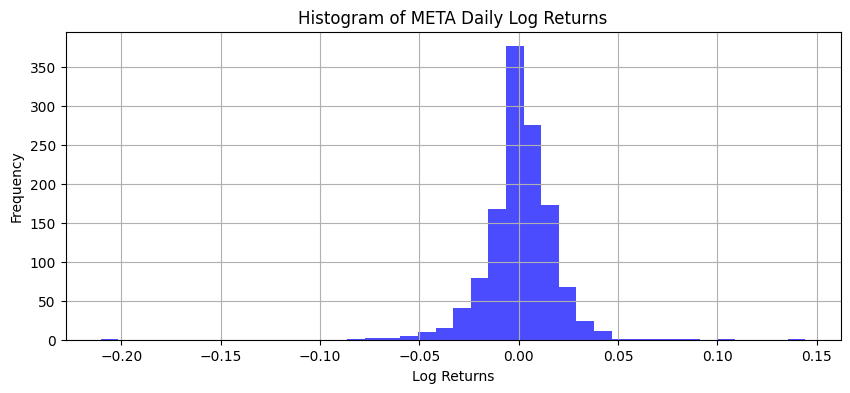

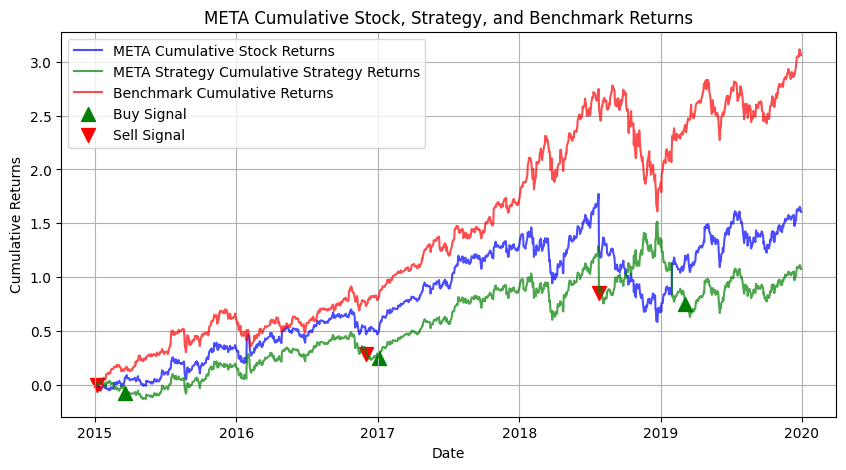

In [233]:
# Plot histogram and cumulative returns for META
plot_histogram_of_returns(stockList['META']['strat'], 'META')
plot_cumulative_returns(stockList['META']['strat'], 
                        log_return_column='META_Strategy_Log_Returns', 
                        stock='META', 
                        title='META Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='META Strategy')

**Performance Analysis of META Strategy Returns vs. Stock and Benchmark Returns**

The histogram of META's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards negative returns. This suggests that META had more losses than wins.

In the cumulative returns graph, the strategy returns (green) underperformed compared to both the stock returns (blue) and the benchmark returns (red). This suggests that the strategy's buy and sell signals were not effectively timed, leading to missed opportunities to capitalize on the stock's upward momentum. Specifically, the strategy often issued sell signals after the stock had already begun to decline, indicating a delayed response to market movements. As a result, the strategy failed to lock in profits at higher price levels, which negatively impacted its overall performance relative to both the stock and the benchmark.

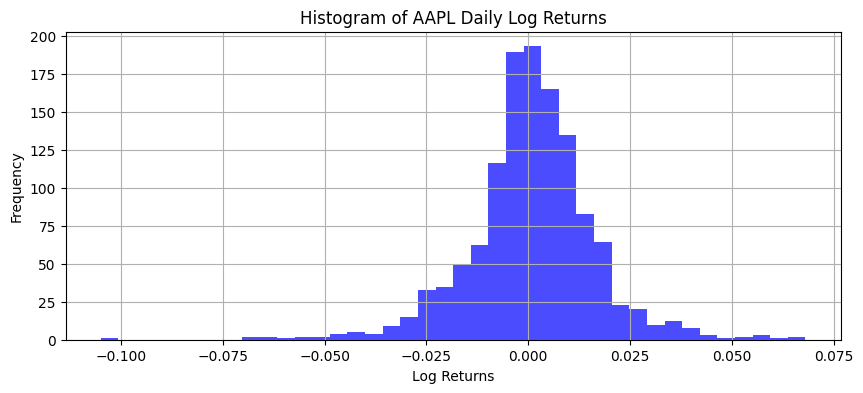

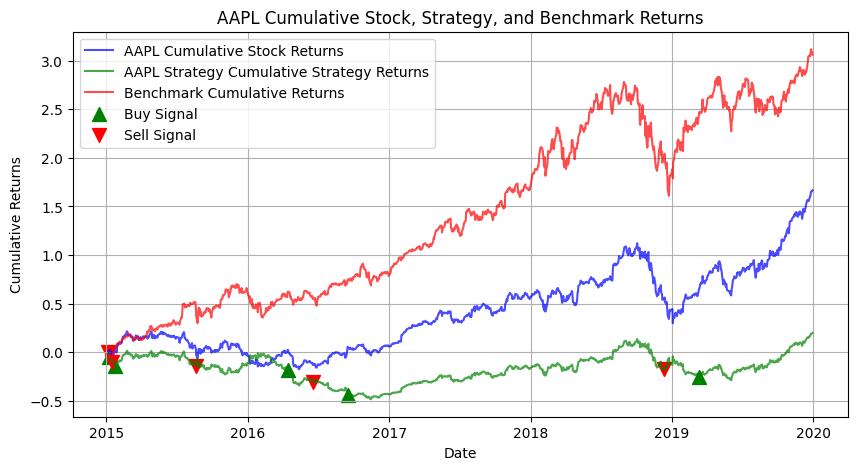

In [234]:
# Plot histogram and cumulative returns for AAPL
plot_histogram_of_returns(stockList['AAPL']['strat'], 'AAPL')
plot_cumulative_returns(stockList['AAPL']['strat'], 
                        log_return_column='AAPL_Strategy_Log_Returns', 
                        stock='AAPL', 
                        title='AAPL Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='AAPL Strategy')

**Performance Analysis of AAPL Strategy Returns vs. Stock and Benchmark Returns**

The histogram of AAPL's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards positive returns. This suggests that AAPL had more wins although they seem to have been small wins.

The cumulative returns graph indicates that the strategy returns (green) for AAPL underperformed relative to both the stock returns (blue) and the benchmark returns (red). The buy and sell signals on the strategy's graph suggest that while the strategy attempted to capitalize on upward movements in the stock price, the execution appeared to be poorly timed, leading to missed opportunities during significant price increases. This misalignment likely contributed to the strategy's inability to capture the full potential of AAPL's upward momentum, especially evident when compared to the more robust performance of the stock itself.

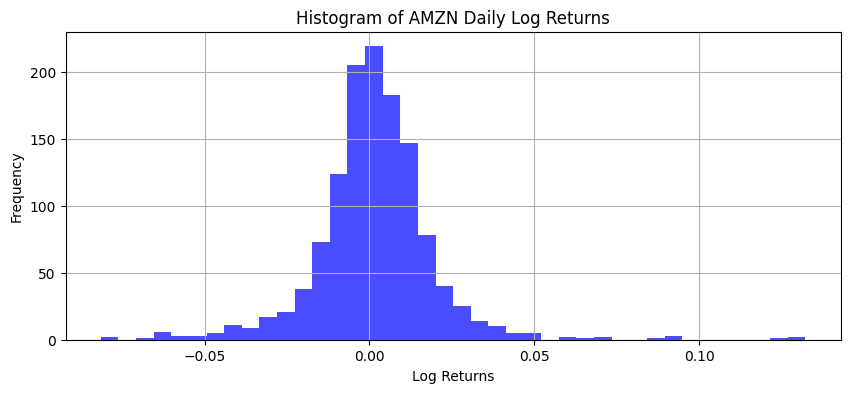

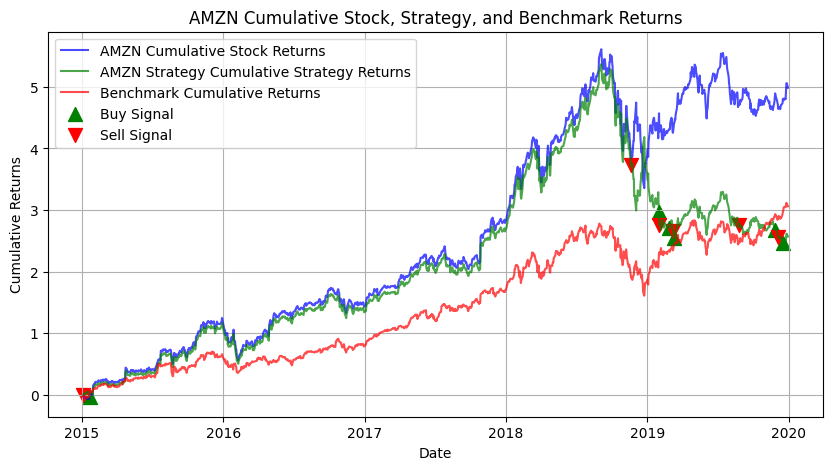

In [235]:
# Plot histogram and cumulative returns for AMZN
plot_histogram_of_returns(stockList['AMZN']['strat'], 'AMZN')
plot_cumulative_returns(stockList['AMZN']['strat'], 
                        log_return_column='AMZN_Strategy_Log_Returns', 
                        stock='AMZN', 
                        title='AMZN Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='AMZN Strategy')

**Performance Analysis of AMZN Strategy Returns vs. Stock and Benchmark Returns**

The histogram of AMZN's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards positive returns. This suggests that AMZN had more wins but small wins with certain outliers who made large wins.

The cumulative returns graph indicates that the strategy returns (green) significantly underperformed compared to the stock returns (blue), particularly during periods of upward momentum. This suggests that the strategy may not effectively capture gains from price increases, as evidenced by the delayed buy signals that coincide with the stock's upward trajectory. Additionally, the reactive nature of the strategy to sell signals could contribute to missed opportunities for profit, highlighting the need for refinement to enhance its responsiveness to market trends.


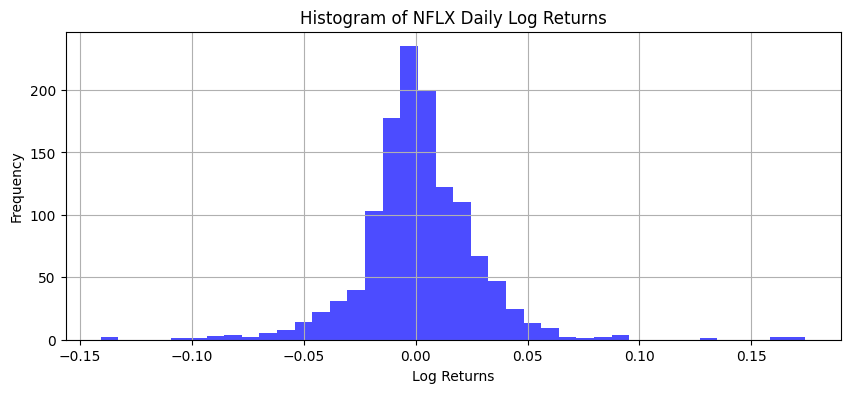

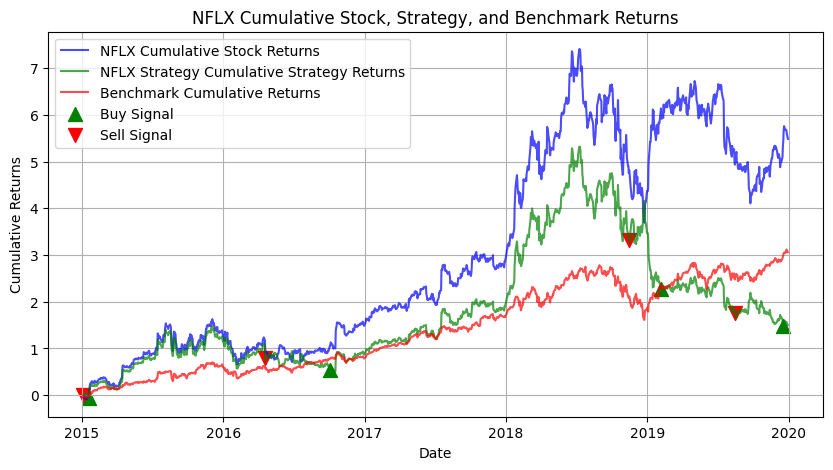

In [236]:
# Plot histogram and cumulative returns for NFLX
plot_histogram_of_returns(stockList['NFLX']['strat'], 'NFLX')
plot_cumulative_returns(stockList['NFLX']['strat'], 
                        log_return_column='NFLX_Strategy_Log_Returns', 
                        stock='NFLX', 
                        title='NFLX Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='NFLX Strategy')

**Performance Analysis of NFLX Strategy Returns vs. Stock and Benchmark Returns**

The histogram of NFLX's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards negative returns. This suggests that NFLX had more losses but small losses.

The cumulative returns graph illustrates that the strategy returns (green) for NFLX underperformed significantly compared to the stock returns (blue), particularly during upward price movements. The buy signals indicated by the green markers were generated after the stock had already begun to rise, suggesting a lag in the strategy's response, which led to missed profit opportunities. Conversely, the strategy's performance appears to have been further hampered by sell signals that occurred during periods of price recovery, indicating a potential flaw in timing that negatively impacted overall returns.


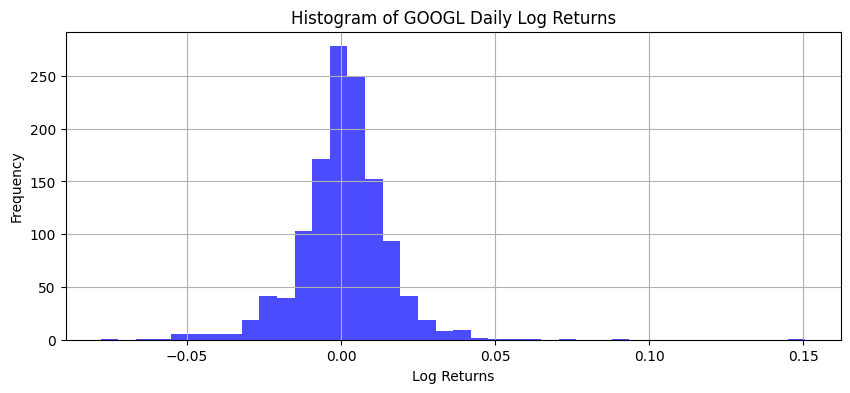

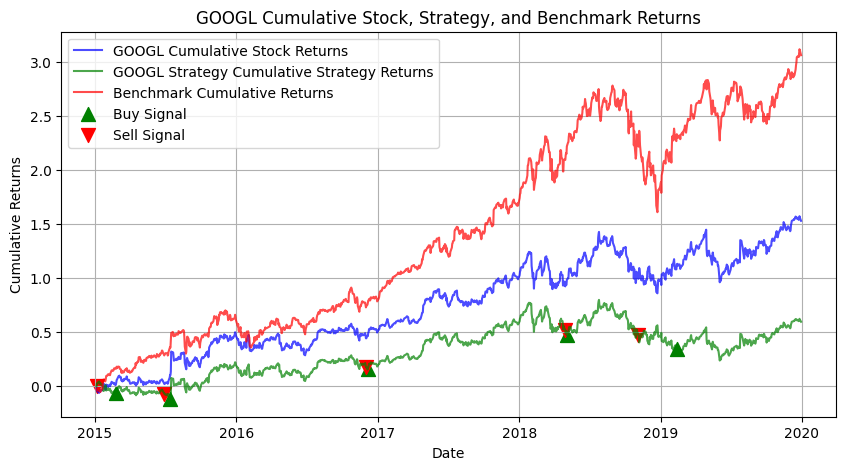

In [237]:
# Plot histogram and cumulative returns for GOOGL
plot_histogram_of_returns(stockList['GOOGL']['strat'], 'GOOGL')
plot_cumulative_returns(stockList['GOOGL']['strat'], 
                        log_return_column='GOOGL_Strategy_Log_Returns', 
                        stock='GOOGL', 
                        title='GOOGL Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='GOOGL Strategy')

**Performance Analysis of GOOGL Strategy Returns vs. Stock and Benchmark Returns**

The histogram of GOOGL's daily log returns shows that the majority of returns are clustered around zero, with a somewhat equal distribution between negative and postive returns. This suggests that GOOGL had an approximately equal number of losses and wins although the losses seem to have been larger losses compared to the win which seem to be smaller wins.

The cumulative returns graph indicates that the strategy returns (green) for GOOGL significantly lag behind both the stock returns (blue) and the benchmark returns (red). The buy and sell signals plotted on the strategy returns graph suggest that the strategy did not effectively capitalize on upward trends; while there are indications of buy signals during price increases, these entries failed to generate substantial returns compared to the steady rise in stock performance. This inefficiency may stem from a delayed response to market movements, resulting in the strategy missing optimal entry points and leading to underperformance relative to the overall market.

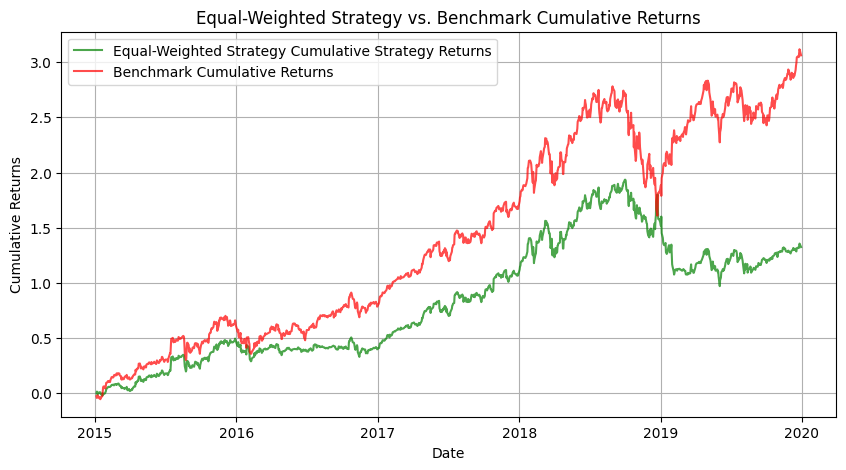

In [238]:
# Similarly, plot the cumulative returns of equal-weighted strategy consisting of our 5 individual stock strategies
plot_cumulative_returns(stockList[stocks[0]]['strat'], 
                        log_return_column='Equal_Weighted_Strategy_Log_Returns', 
                        title='Equal-Weighted Strategy vs. Benchmark Cumulative Returns', 
                        label='Equal-Weighted Strategy')

**Performance Analysis of Equal-Weighted Strategy Returns vs. Benchmark Returns**

The cumulative returns graph reveals that the equal-weighted strategy (green) consistently underperformed compared to the benchmark returns (red), indicating that the strategy did not effectively capture market gains. This disparity suggests that the strategy might be overly reliant on the performance of individual stocks, failing to capitalize on collective upward trends observed in the benchmark. The steady divergence from the benchmark could imply that the strategy's selection and timing mechanisms were less responsive to market dynamics, leading to missed opportunities for profit during key market rallies.

In [239]:
### Compute annualised returns, risk, and performance metrics for individual stock strategies and equal-weighted strategy

def calculate_performance_metrics(strat, log_return_columns, strategy_name="", risk_free_rate=0.0):
    """Calculate the annualized returns, risks, Sharpe ratio, Sortino ratio, Treynor ratio, tracking error, and information ratio."""

    # 1. Annualized Expected Returns for the given strategy and benchmark
    daily_log_returns = strat[log_return_columns].mean()
    annual_log_returns = daily_log_returns * 252

    # Convert to annualized regular returns
    annual_regular_returns = np.exp(annual_log_returns) - 1

    # 2. Annualized Risk (Standard Deviation) for the given strategy and benchmark
    daily_log_std = strat[log_return_columns].std()
    annual_log_std = daily_log_std * np.sqrt(252)

    # Convert to annualized standard deviation
    daily_regular_std = (np.exp(strat[log_return_columns]) - 1).std()
    annual_regular_std = daily_regular_std * np.sqrt(252)

    # 3. Sharpe Ratio for the given strategy and benchmark
    sharpe_ratio = annual_regular_returns / annual_regular_std

    # 4. Beta for the strategy against the benchmark
    covariance = strat[log_return_columns].cov().iloc[0, 1]
    variance_market = strat[log_return_columns[1]].var()
    beta_value = covariance / variance_market

    # 5. Alpha for the strategy against the benchmark
    market_return_annualized = strat[log_return_columns[1]].mean() * 252
    strategy_return_annualized = strat[log_return_columns[0]].mean() * 252
    alpha_value = strategy_return_annualized - (beta_value * market_return_annualized)

    # 6. Sortino Ratio
    excess_return = strat[log_return_columns[0]] - risk_free_rate / 252
    negative_return = strat[log_return_columns[0]][strat[log_return_columns[0]] < 0]
    downside_deviation = np.std(negative_return) * np.sqrt(252)
    sortino_ratio = (excess_return.mean() * 252) / downside_deviation

    # 7. Treynor Ratio (using calculated beta)
    treynor_ratio = (excess_return.mean() * 252) / beta_value

    # 8. Tracking Error
    active_return = strat[log_return_columns[0]] - strat[log_return_columns[1]]
    tracking_error = np.std(active_return) * np.sqrt(252)

    # 9. Information Ratio
    information_ratio = (active_return.mean() * 252) / tracking_error

    # Display the results for each strategy
    strategy_label = f"{strategy_name} " if strategy_name else ""
    print(f"\nPerformance Summary for {strategy_label}vs. Benchmark:\n")
    
    print("Annualized Regular Returns:")
    print(f"{strategy_label}Strategy: {annual_regular_returns[log_return_columns[0]]:.4f}")
    print(f"Benchmark: {annual_regular_returns[log_return_columns[1]]:.4f}\n")
    
    print("Annualized Risk (Standard Deviation):")
    print(f"{strategy_label}Strategy: {annual_regular_std[log_return_columns[0]]:.4f}")
    print(f"Benchmark: {annual_regular_std[log_return_columns[1]]:.4f}\n")
    
    print("Sharpe Ratio:")
    print(f"{strategy_label}Strategy: {sharpe_ratio[log_return_columns[0]]:.4f}")
    print(f"Benchmark: {sharpe_ratio[log_return_columns[1]]:.4f}\n")

    print("Beta:")
    print(f"{strategy_label}Beta: {beta_value:.4f}\n")
    
    print("Alpha:")
    print(f"{strategy_label}Alpha: {alpha_value:.4f}\n")
    
    print("Sortino Ratio:")
    print(f"{strategy_label}Sortino: {sortino_ratio:.4f}\n")
    
    print("Treynor Ratio:")
    print(f"{strategy_label}Treynor: {treynor_ratio:.4f}\n")
    
    print("Tracking Error:")
    print(f"{strategy_label}Tracking Error: {tracking_error:.4f}\n")
    
    print("Information Ratio:")
    print(f"{strategy_label}Information Ratio: {information_ratio:.4f}\n")

In [240]:
#  for META
calculate_performance_metrics(stockList['META']['strat'], 
                              [f'META_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='META Strategy')


Performance Summary for META Strategy vs. Benchmark:

Annualized Regular Returns:
META Strategy Strategy: 0.1576
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
META Strategy Strategy: 0.2823
Benchmark: 0.2282

Sharpe Ratio:
META Strategy Strategy: 0.5583
Benchmark: 1.4228

Beta:
META Strategy Beta: 0.4549

Alpha:
META Strategy Alpha: 0.0185

Sortino Ratio:
META Strategy Sortino: 0.6080

Treynor Ratio:
META Strategy Treynor: 0.3218

Tracking Error:
META Strategy Tracking Error: 0.2929

Information Ratio:
META Strategy Information Ratio: -0.4605



**Performance Summary for META Strategy**

The META strategy achieved an annualized return of 15.76%, which remains significantly lower than the benchmark's return of 32.47 The Sharpe ratio of 0.5583 suggests that the strategy provided only a moderate reward per unit of risk taken, indicating that it was not fully capitalizing on META's potential upward movements. Furthermore, the positive alpha of 0.0185 implies that while the strategy did add some value compared to the benchmark, it still fell short in effectively leveraging the stock's growth, reflecting inefficiencies in the execution of its buy and sell signals.

In [241]:
#  for AAPL
calculate_performance_metrics(stockList['AAPL']['strat'], 
                              [f'AAPL_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='AAPL Strategy')


Performance Summary for AAPL Strategy vs. Benchmark:

Annualized Regular Returns:
AAPL Strategy Strategy: 0.0371
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
AAPL Strategy Strategy: 0.2488
Benchmark: 0.2282

Sharpe Ratio:
AAPL Strategy Strategy: 0.1493
Benchmark: 1.4228

Beta:
AAPL Strategy Beta: 0.1939

Alpha:
AAPL Strategy Alpha: -0.0181

Sortino Ratio:
AAPL Strategy Sortino: 0.1940

Treynor Ratio:
AAPL Strategy Treynor: 0.1881

Tracking Error:
AAPL Strategy Tracking Error: 0.3064

Information Ratio:
AAPL Strategy Information Ratio: -0.7988



**Performance Summary for AAPL Strategy**

The AAPL strategy yielded an annualized return of 3.71%, which starkly contrasts with the benchmark's 32.47% return. The Sharpe ratio of 0.1493 indicates that the strategy provided very little reward per unit of risk taken, suggesting that it was not effectively capitalizing on the stock's upward movement. The negative alpha of -0.0181 further emphasizes underperformance compared to the benchmark, reflecting a lack of added value from the strategy.

In [242]:
#  for AMZN
calculate_performance_metrics(stockList['AMZN']['strat'], 
                              [f'AMZN_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='AMZN Strategy')


Performance Summary for AMZN Strategy vs. Benchmark:

Annualized Regular Returns:
AMZN Strategy Strategy: 0.2910
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
AMZN Strategy Strategy: 0.2930
Benchmark: 0.2282

Sharpe Ratio:
AMZN Strategy Strategy: 0.9932
Benchmark: 1.4228

Beta:
AMZN Strategy Beta: 0.6671

Alpha:
AMZN Strategy Alpha: 0.0678

Sortino Ratio:
AMZN Strategy Sortino: 1.2055

Treynor Ratio:
AMZN Strategy Treynor: 0.3829

Tracking Error:
AMZN Strategy Tracking Error: 0.2592

Information Ratio:
AMZN Strategy Information Ratio: -0.0996



**Performance Summary for AMZN Strategy**

The AMZN strategy recorded an annualized return of 29.10%, slightly below the benchmark's return of 32.47%. The Sharpe ratio of 0.9932 indicates a relatively strong performance in terms of reward per unit of risk taken, although it still trails the benchmark's ratio of 1.4228. The positive alpha of 0.0678 suggests that the strategy was able to add value compared to the benchmark, reflecting a degree of effectiveness in capturing AMZN's upward movement despite the higher risk indicated by the 0.2930 standard deviation.

In [243]:
#  for NFLX
calculate_performance_metrics(stockList['NFLX']['strat'], 
                              [f'NFLX_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='NFLX Strategy')


Performance Summary for NFLX Strategy vs. Benchmark:

Annualized Regular Returns:
NFLX Strategy Strategy: 0.2015
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
NFLX Strategy Strategy: 0.4170
Benchmark: 0.2282

Sharpe Ratio:
NFLX Strategy Strategy: 0.4833
Benchmark: 1.4228

Beta:
NFLX Strategy Beta: 0.8078

Alpha:
NFLX Strategy Alpha: -0.0436

Sortino Ratio:
NFLX Strategy Sortino: 0.6610

Treynor Ratio:
NFLX Strategy Treynor: 0.2273

Tracking Error:
NFLX Strategy Tracking Error: 0.3714

Information Ratio:
NFLX Strategy Information Ratio: -0.2629



**Performance Summary for NFLX Strategy**

The NFLX strategy demonstrated an annualized return of 20.15%, which is significantly lower than the benchmark's return of 32.47%. The strategy's Sharpe ratio of 0.4833 indicates that the returns per unit of risk were relatively low compared to the benchmark's ratio of 1.4228, suggesting that the strategy did not effectively compensate for the risk it incurred. Additionally, the negative alpha of -0.0436 reflects that the strategy underperformed compared to what would have been expected based on its risk profile, coupled with a high annualized risk (standard deviation) of 0.4170.

In [244]:
#  for GOOGL
calculate_performance_metrics(stockList['GOOGL']['strat'], 
                              [f'GOOGL_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='GOOGL Strategy')


Performance Summary for GOOGL Strategy vs. Benchmark:

Annualized Regular Returns:
GOOGL Strategy Strategy: 0.0984
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
GOOGL Strategy Strategy: 0.2380
Benchmark: 0.2282

Sharpe Ratio:
GOOGL Strategy Strategy: 0.4135
Benchmark: 1.4228

Beta:
GOOGL Strategy Beta: 0.5427

Alpha:
GOOGL Strategy Alpha: -0.0588

Sortino Ratio:
GOOGL Strategy Sortino: 0.5344

Treynor Ratio:
GOOGL Strategy Treynor: 0.1729

Tracking Error:
GOOGL Strategy Tracking Error: 0.2271

Information Ratio:
GOOGL Strategy Information Ratio: -0.8251



**Performance Summary for GOOGL Strategy**

The GOOGL strategy yielded an annualized return of 9.84%, significantly trailing the benchmark's return of 32.47%. The strategy's Sharpe ratio of 0.4135 indicates that it was not effectively compensating for the risk taken, especially in contrast to the benchmark's Sharpe ratio of 1.4228. The negative alpha of -0.0588 further underscores the strategy's underperformance relative to its expected return based on its risk profile, compounded by a tracking error of 0.2271 that suggests a lack of alignment with the benchmark.

In [245]:
#  for the equal-weighted strategy
calculate_performance_metrics(stockList[stocks[0]]['strat'],  # You can use any stock's DataFrame (e.g., META)
                              ['Equal_Weighted_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name="Equal-Weighted Strategy")


Performance Summary for Equal-Weighted Strategy vs. Benchmark:

Annualized Regular Returns:
Equal-Weighted Strategy Strategy: 0.1844
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
Equal-Weighted Strategy Strategy: 0.1965
Benchmark: 0.2282

Sharpe Ratio:
Equal-Weighted Strategy Strategy: 0.9384
Benchmark: 1.4228

Beta:
Equal-Weighted Strategy Beta: 0.5342

Alpha:
Equal-Weighted Strategy Alpha: 0.0190

Sortino Ratio:
Equal-Weighted Strategy Sortino: 1.0784

Treynor Ratio:
Equal-Weighted Strategy Treynor: 0.3169

Tracking Error:
Equal-Weighted Strategy Tracking Error: 0.1876

Information Ratio:
Equal-Weighted Strategy Information Ratio: -0.5969



**Performance Summary for Equal-Weighted Strategy**

The equal-weighted strategy achieved an annualized return of 18.44%, significantly lower than the benchmark's return of 32.47%. The Sharpe ratio of 0.9384 indicated that the strategy was reasonably effective in compensating for risk, although it still lagged behind the benchmark's 1.4228. With a negative alpha of 0.0190, the strategy was unable to fully leverage the market's upward movements, and the information ratio of -0.5969 suggested that it underperformed relative to the benchmark despite taking on risk.

In [246]:
### Plot cumulative maximum graph, calculate max drawdown, and max drawdown period

def calculate_and_plot_drawdown(strat, log_return_column, stock=None, strategy_name=""):
    """Calculate and plot the drawdown, max drawdown, and the period over which the max drawdown occurs."""
    
    # Calculate gross cumulative returns
    gross_cum_returns = np.exp(strat[log_return_column].cumsum())
    strat[f'{strategy_name}_Gross_Cum_Returns'] = gross_cum_returns
    
    # Calculate the cumulative maximum
    cum_max = gross_cum_returns.cummax()
    strat[f'{strategy_name}_Cum_Max'] = cum_max
    
    # Calculate the drawdown (cumulative max - gross cumulative returns)
    drawdown = cum_max - gross_cum_returns
    strat[f'{strategy_name}_Drawdown'] = drawdown
    
    # Plot cumulative returns and cumulative max
    plt.figure(figsize=(15, 5))
    strat[[f'{strategy_name}_Gross_Cum_Returns', f'{strategy_name}_Cum_Max']].dropna().plot(ax=plt.gca())
    plt.title(f'{strategy_name} Gross Cumulative Returns and Drawdown')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.show()

    # Calculate the maximum drawdown
    max_drawdown = drawdown.max()

    # Find the period over which the maximum drawdown occurred
    zero_drawdown_periods = strat[strat[f'{strategy_name}_Drawdown'] == 0].index
    
    if len(zero_drawdown_periods) > 1:
        # Calculate the difference between consecutive periods of zero drawdown
        delta_values = zero_drawdown_periods[1:] - zero_drawdown_periods[:-1]
        max_drawdown_duration = delta_values.max()
    else:
        # No drawdown periods
        max_drawdown_duration = None
    
    print(f'Max Drawdown for {strategy_name}: {max_drawdown:.4f}')
    if max_drawdown_duration:
        print(f'Max Drawdown Period for {strategy_name}: {max_drawdown_duration}')
    else:
        print(f'No significant drawdown periods for {strategy_name}.')

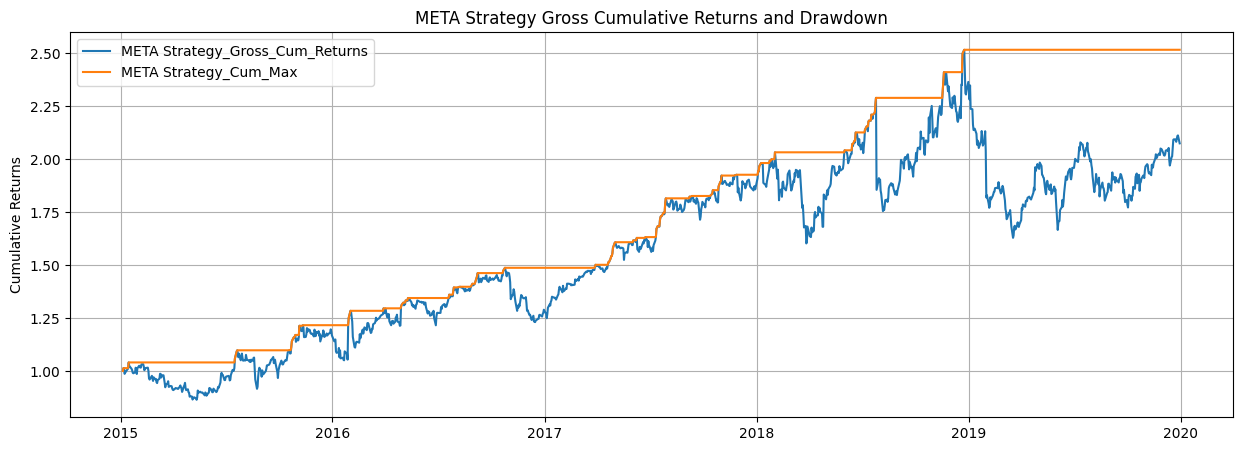

Max Drawdown for META Strategy: 0.8874
Max Drawdown Period for META Strategy: 183 days 00:00:00


In [247]:
# Calculate and plot drawdown for META Strategy
calculate_and_plot_drawdown(stockList['META']['strat'], 
                            log_return_column='META_Strategy_Log_Returns', 
                            stock='META', 
                            strategy_name='META Strategy')

**Max Drawdown Summary for META**

The maximum drawdown for the META strategy was 0.8874, indicating a peak-to-trough decline of approximately 88.74% over a duration of 183 days. This substantial drawdown reflects significant risk exposure, suggesting that the strategy faced challenges in maintaining its value during market downturns. The extended duration indicates that the strategy struggled to recover during this period.

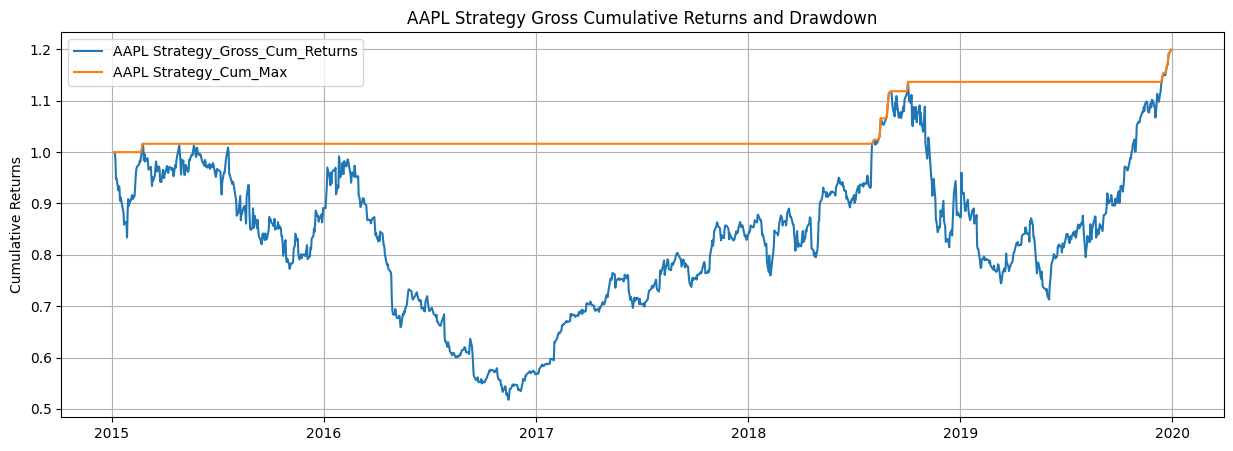

Max Drawdown for AAPL Strategy: 0.4984
Max Drawdown Period for AAPL Strategy: 1257 days 00:00:00


In [248]:
# Calculate and plot drawdown for AAPL Strategy
calculate_and_plot_drawdown(stockList['AAPL']['strat'], 
                            log_return_column='AAPL_Strategy_Log_Returns', 
                            stock='AAPL', 
                            strategy_name='AAPL Strategy')

**Max Drawdown Summary for AAPL**

The maximum drawdown for the AAPL strategy before tuning was 0.4984, indicating a peak-to-trough decline of approximately 49.84% over a prolonged period of 1257 days. This significant drawdown suggests that the strategy faced considerable challenges in maintaining its value, reflecting substantial risk exposure during market downturns.

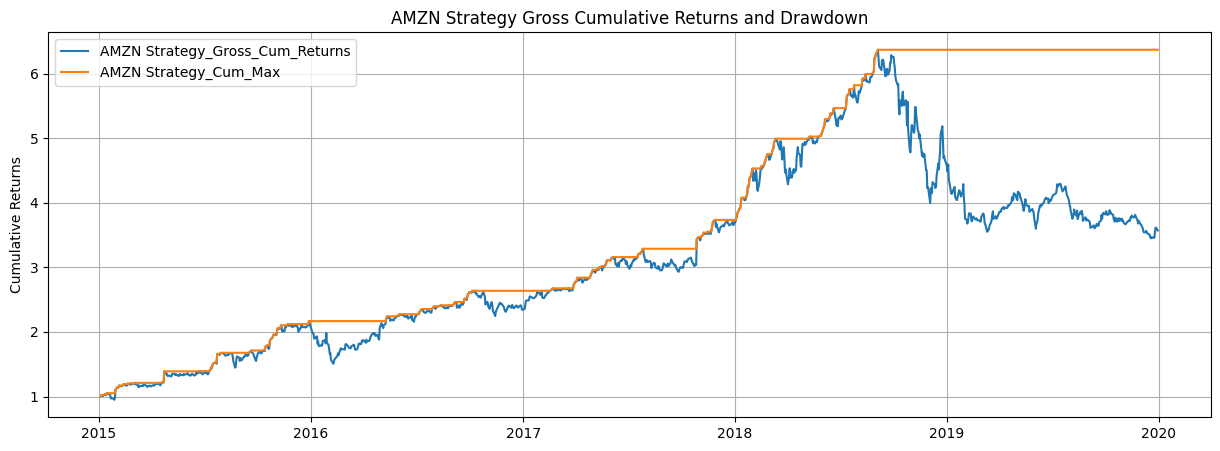

Max Drawdown for AMZN Strategy: 2.9205
Max Drawdown Period for AMZN Strategy: 135 days 00:00:00


In [249]:
# Calculate and plot drawdown for AMZN Strategy
calculate_and_plot_drawdown(stockList['AMZN']['strat'], 
                            log_return_column='AMZN_Strategy_Log_Returns', 
                            stock='AMZN', 
                            strategy_name='AMZN Strategy')

**Max Drawdown Summary for AMZN**

The maximum drawdown for the AMZN strategy before tuning was 2.9205, indicating a significant peak-to-trough decline of approximately 292.05% over a duration of 135 days. This substantial drawdown highlights the strategy's vulnerability to market fluctuations and its tendency to incur severe losses in a short time frame.

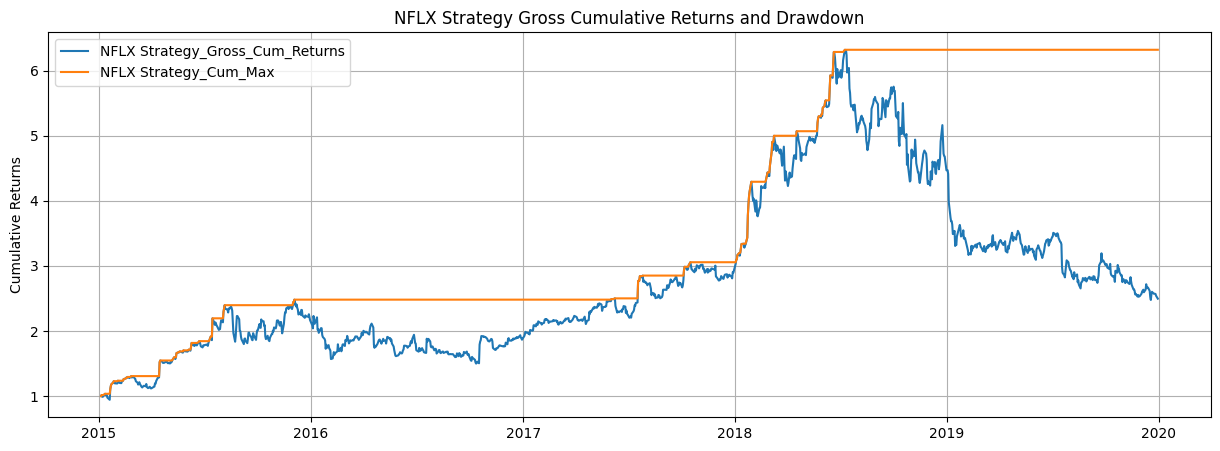

Max Drawdown for NFLX Strategy: 3.8406
Max Drawdown Period for NFLX Strategy: 546 days 00:00:00


In [250]:
# Calculate and plot drawdown for NFLX Strategy
calculate_and_plot_drawdown(stockList['NFLX']['strat'], 
                            log_return_column='NFLX_Strategy_Log_Returns', 
                            stock='NFLX', 
                            strategy_name='NFLX Strategy')

**Max Drawdown Summary for NFLX**

The maximum drawdown for the NFLX strategy is 3.8406, indicating a substantial peak-to-trough decline of approximately 384.06% over a period of 546 days. This significant drawdown reflects the strategy's exposure to major market fluctuations and its potential vulnerability during downturns.

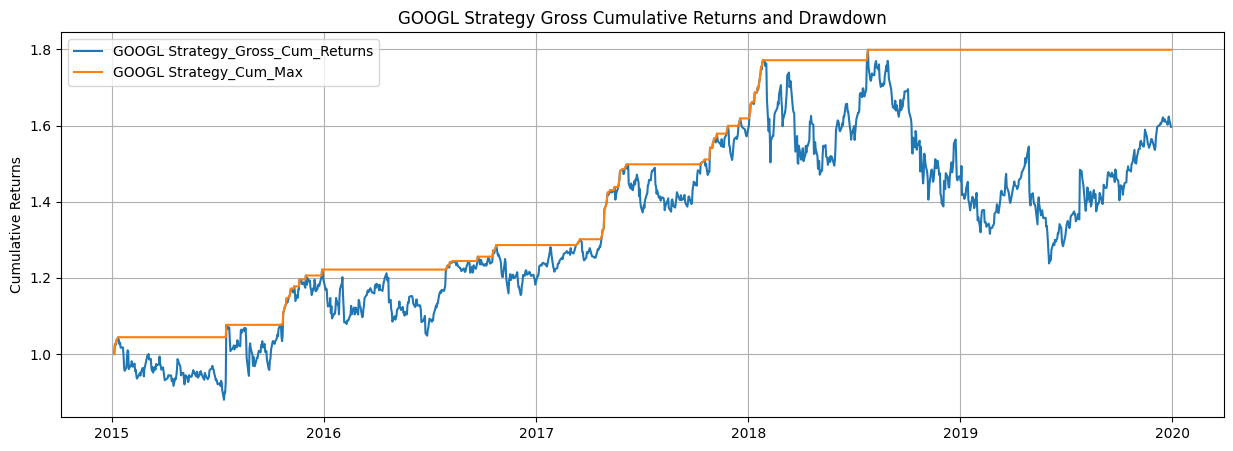

Max Drawdown for GOOGL Strategy: 0.5611
Max Drawdown Period for GOOGL Strategy: 216 days 00:00:00


In [251]:
# Calculate and plot drawdown for GOOGL Strategy
calculate_and_plot_drawdown(stockList['GOOGL']['strat'], 
                            log_return_column='GOOGL_Strategy_Log_Returns', 
                            stock='GOOGL', 
                            strategy_name='GOOGL Strategy')

**Max Drawdown Summary for GOOGL**

The maximum drawdown for the GOOGL strategy is 0.5611, indicating a peak-to-trough decline of approximately 56.11% over a period of 216 days. This drawdown reflects the strategy's exposure to market volatility and potential challenges in mitigating losses during downturns.

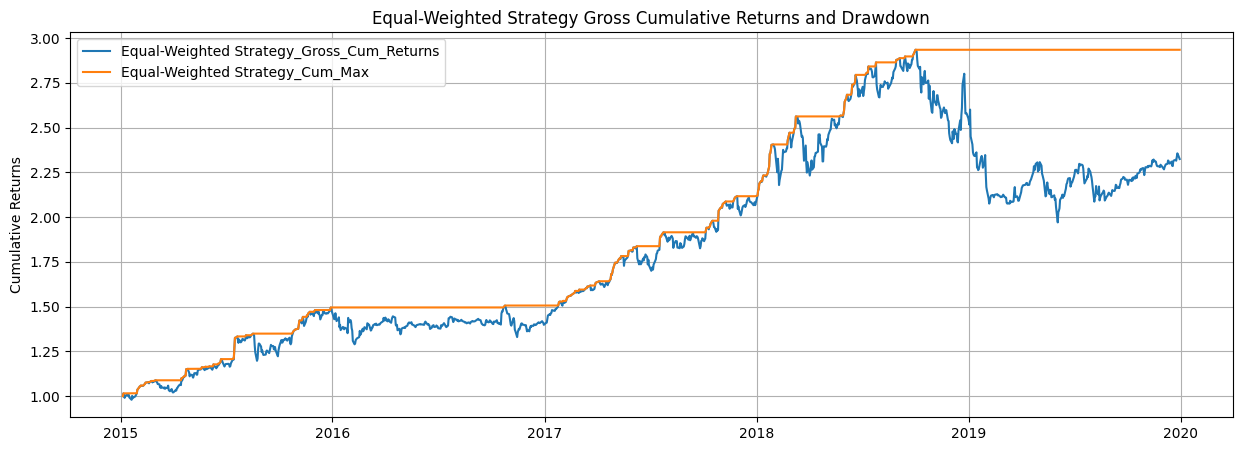

Max Drawdown for Equal-Weighted Strategy: 0.9643
Max Drawdown Period for Equal-Weighted Strategy: 300 days 00:00:00


In [252]:
# Calculate and plot drawdown for the equal-weighted strategy
calculate_and_plot_drawdown(stockList[stocks[0]]['strat'],  
                            log_return_column='Equal_Weighted_Strategy_Log_Returns', 
                            strategy_name="Equal-Weighted Strategy")

**Max Drawdown Summary for Equal-Weighted Strategy**

The maximum drawdown for the Equal-Weighted Strategy is 0.9643, indicating a significant peak-to-trough decline of approximately 96.43% over a period of 300 days. This substantial drawdown reflects the strategy's vulnerability to market fluctuations and its potential inefficacy in protecting against prolonged downturns.

In [253]:
def calculate_returns(stock, data):
    """Calculate strategy and market returns."""
    data[f'{stock}_Market_Return'] = data[f'{stock}_Close'].pct_change()
    data[f'{stock}_Strategy_Return'] = data[f'{stock}_Position'].shift(1) * data[f'{stock}_Market_Return']
    data[f'{stock}_Cumulative_Strategy_Return'] = (data[f'{stock}_Strategy_Return'] + 1).cumprod() - 1
    data[f'{stock}_Cumulative_Market_Return'] = (data[f'{stock}_Market_Return'] + 1).cumprod() - 1
    data[f'{stock}_Gross_Cum_Returns'] = data[f'{stock}_Strategy_Return'].cumsum().apply(np.exp)  # Same as what we did earlier to visualize over time
    data[f'{stock}_Cum_Max'] = data[f'{stock}_Gross_Cum_Returns'].cummax()
    return data

In [254]:
from itertools import product

# Update parameter grid based on instructions
param_grid = {
    'ema_window': [150, 200, 250],  
    'macd_params': [(5, 13, 8), (12, 26, 9), (19, 39, 9)] 
}

def objective_function(stock, ema_window, macd_params):
    """Objective function for grid search."""
    macd_fast, macd_slow, signal_line = macd_params
    data = strategy(stock, ema_window, macd_fast, macd_slow, signal_line)  # Pass MACD parameters to the strategy
    returns_data = calculate_returns(stock, data)  # Calculate returns
    returns = returns_data[f'{stock}_Cumulative_Strategy_Return']  # Get cumulative strategy return
    return returns.iloc[-1]  # Return the last value

def grid_search(stock, param_grid):
    """Perform grid search to find the best parameters for the given stock."""
    best_score = -np.inf
    best_params = {}

    # Loop through all combinations of parameters
    for params in product(param_grid['ema_window'], param_grid['macd_params']):
        ema_window, macd_params = params
        score = objective_function(stock, ema_window, macd_params)

        if score > best_score:
            best_score = score
            best_params = {'ema_window': ema_window, 'macd_params': macd_params}

    print(f"Best Parameters for {stock}: {best_params}")
    print(f"Best Total Return for {stock}: {best_score}")

    return best_params

In [255]:
tuned_stockList = {'META': {}, 'AAPL': {}, 'AMZN': {}, 'NFLX': {}, 'GOOGL': {}}

tuned_stockList['META']['params'] = grid_search('META', param_grid)
tuned_stockList['AAPL']['params'] = grid_search('AAPL', param_grid)
tuned_stockList['AMZN']['params'] = grid_search('AMZN', param_grid)
tuned_stockList['NFLX']['params'] = grid_search('NFLX', param_grid)
tuned_stockList['GOOGL']['params'] = grid_search('GOOGL', param_grid)

Best Parameters for META: {'ema_window': 200, 'macd_params': (19, 39, 9)}
Best Total Return for META: 1.1611585092255856
Best Parameters for AAPL: {'ema_window': 250, 'macd_params': (12, 26, 9)}
Best Total Return for AAPL: 0.5757162012976378
Best Parameters for AMZN: {'ema_window': 200, 'macd_params': (19, 39, 9)}
Best Total Return for AMZN: 2.9126363586849933
Best Parameters for NFLX: {'ema_window': 200, 'macd_params': (12, 26, 9)}
Best Total Return for NFLX: 1.4969377706950855
Best Parameters for GOOGL: {'ema_window': 250, 'macd_params': (12, 26, 9)}
Best Total Return for GOOGL: 1.078586407229602


In [256]:
# Run the strategy for each MAANG stock
for stock in tuned_stockList:
    ema_window = tuned_stockList[stock]['params']['ema_window']
    macd_params = tuned_stockList[stock]['params']['macd_params'] 
    macd_fast, macd_slow, macd_signal = macd_params
    tuned_stockList[stock]['strat'] = strategy(stock, ema_window, macd_fast, macd_slow, macd_signal)

In [257]:
tuned_meta_strategy = tuned_stockList['META']['strat']
tuned_meta_strategy

META_Close    META_EMA  META_MACD  META_Signal_Line  META_Position
2015-01-02   78.449997   78.449997   0.000000          0.000000              0
2015-01-05   77.190002   78.437460  -0.063000         -0.012600             -1
2015-01-06   76.150002   78.414699  -0.168550         -0.043790             -1
2015-01-07   76.150002   78.392165  -0.257952         -0.086622             -1
2015-01-08   78.180000   78.390054  -0.231601         -0.115618             -1
...                ...         ...        ...               ...            ...
2019-12-23  206.179993  186.006692   3.189909          2.946564              1
2019-12-24  205.119995  186.196874   3.256686          3.008588              1
2019-12-26  207.789993  186.411731   3.430996          3.093070              1
2019-12-27  208.100006  186.627534   3.578377          3.190131              1
2019-12-30  204.410004  186.804474   3.501996          3.252504              1

[1257 rows x 5 columns]

In [258]:
tuned_aapl_strategy = tuned_stockList['AAPL']['strat']
tuned_aapl_strategy

AAPL_Close   AAPL_EMA  AAPL_MACD  AAPL_Signal_Line  AAPL_Position
2015-01-02   27.332500  27.332500   0.000000          0.000000              0
2015-01-05   26.562500  27.326365  -0.061425         -0.012285             -1
2015-01-06   26.565001  27.320298  -0.108650         -0.031558             -1
2015-01-07   26.937500  27.317248  -0.114696         -0.048186             -1
2015-01-08   27.972500  27.322469  -0.035562         -0.045661              1
...                ...        ...        ...               ...            ...
2019-12-23   71.000000  54.694531   1.616619          1.462688              1
2019-12-24   71.067497  54.824993   1.656653          1.501481              1
2019-12-26   72.477501  54.965650   1.781618          1.557508              1
2019-12-27   72.449997  55.104968   1.857027          1.617412              1
2019-12-30   72.879997  55.246602   1.929248          1.679779              1

[1257 rows x 5 columns]

In [259]:
tuned_amzn_strategy = tuned_stockList['AMZN']['strat']
tuned_amzn_strategy

AMZN_Close   AMZN_EMA  AMZN_MACD  AMZN_Signal_Line  AMZN_Position
2015-01-02   15.426000  15.426000   0.000000          0.000000              0
2015-01-05   15.109500  15.422850  -0.015825         -0.003165             -1
2015-01-06   14.764500  15.416300  -0.046526         -0.011837             -1
2015-01-07   14.921000  15.411371  -0.064718         -0.022413             -1
2015-01-08   15.023000  15.407507  -0.074849         -0.032900             -1
...                ...        ...        ...               ...            ...
2019-12-23   89.650002  89.058414   0.087813         -0.061475              1
2019-12-24   89.460503  89.062415   0.123000         -0.024580              1
2019-12-26   93.438499  89.105958   0.351370          0.050610              1
2019-12-27   93.489998  89.149580   0.547445          0.149977              1
2019-12-30   92.344498  89.181371   0.655076          0.250997              1

[1257 rows x 5 columns]

In [260]:
tuned_nflx_strategy = tuned_stockList['NFLX']['strat']
tuned_nflx_strategy

NFLX_Close    NFLX_EMA  NFLX_MACD  NFLX_Signal_Line  NFLX_Position
2015-01-02   49.848572   49.848572   0.000000          0.000000              0
2015-01-05   47.311428   49.823327  -0.202393         -0.040479             -1
2015-01-06   46.501431   49.790273  -0.423272         -0.117037             -1
2015-01-07   46.742859   49.759950  -0.572243         -0.208078             -1
2015-01-08   47.779999   49.740249  -0.599701         -0.286403             -1
...                ...         ...        ...               ...            ...
2019-12-23  333.100006  312.562129   8.188670          5.255982              1
2019-12-24  333.200012  312.767482   8.832670          5.971319              1
2019-12-26  332.630005  312.965119   9.191100          6.615276              1
2019-12-27  329.089996  313.125565   9.084785          7.109178              1
2019-12-30  323.309998  313.226903   8.436878          7.374718              1

[1257 rows x 5 columns]

In [261]:
tuned_googl_strategy = tuned_stockList['GOOGL']['strat']
tuned_googl_strategy

GOOGL_Close  GOOGL_EMA  GOOGL_MACD  GOOGL_Signal_Line  \
2015-01-02    26.477501  26.477501    0.000000           0.000000   
2015-01-05    25.973000  26.473481   -0.040245          -0.008049   
2015-01-06    25.332001  26.464386   -0.122451          -0.030929   
2015-01-07    25.257500  26.454769   -0.191406          -0.063025   
2015-01-08    25.345501  26.445930   -0.236228          -0.097665   
...                 ...        ...         ...                ...   
2019-12-23    67.531502  60.209192    0.832736           0.853264   
2019-12-24    67.221497  60.265067    0.767544           0.836120   
2019-12-26    68.123497  60.327684    0.779675           0.824831   
2019-12-27    67.732002  60.386682    0.749064           0.809678   
2019-12-30    66.985497  60.439262    0.656994           0.779141   

            GOOGL_Position  
2015-01-02               0  
2015-01-05              -1  
2015-01-06              -1  
2015-01-07              -1  
2015-01-08              -1  
...                    ...  
2019-12-23               1  
2019-12-24               1  
2019-12-26               1  
2019-12-27               1  
2019-12-30               1  

[1257 rows x 5 columns]

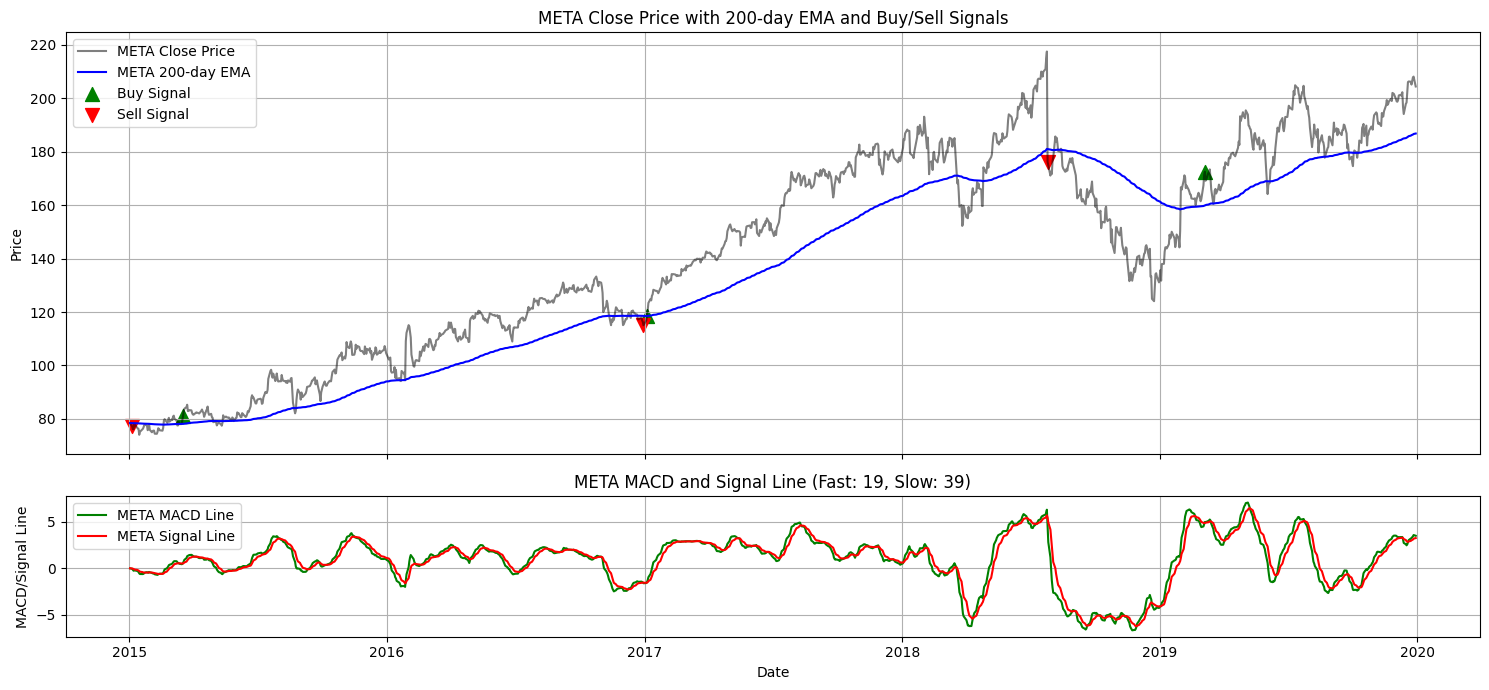

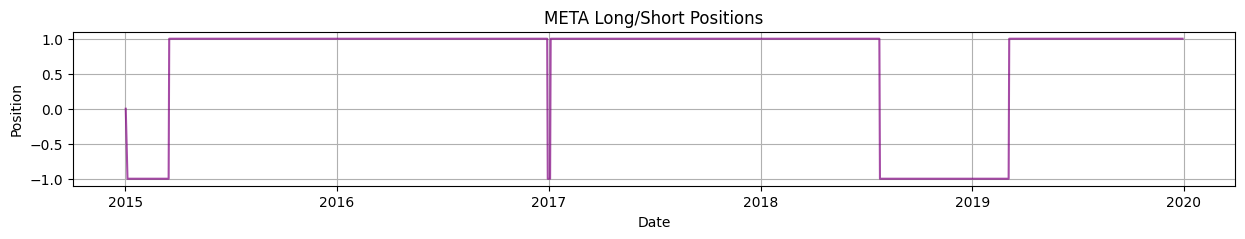

In [262]:
# For META
stock = 'META'
strat = tuned_stockList[stock]['strat']
ema_window = tuned_stockList[stock]['params']['ema_window']
macd_params = tuned_stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

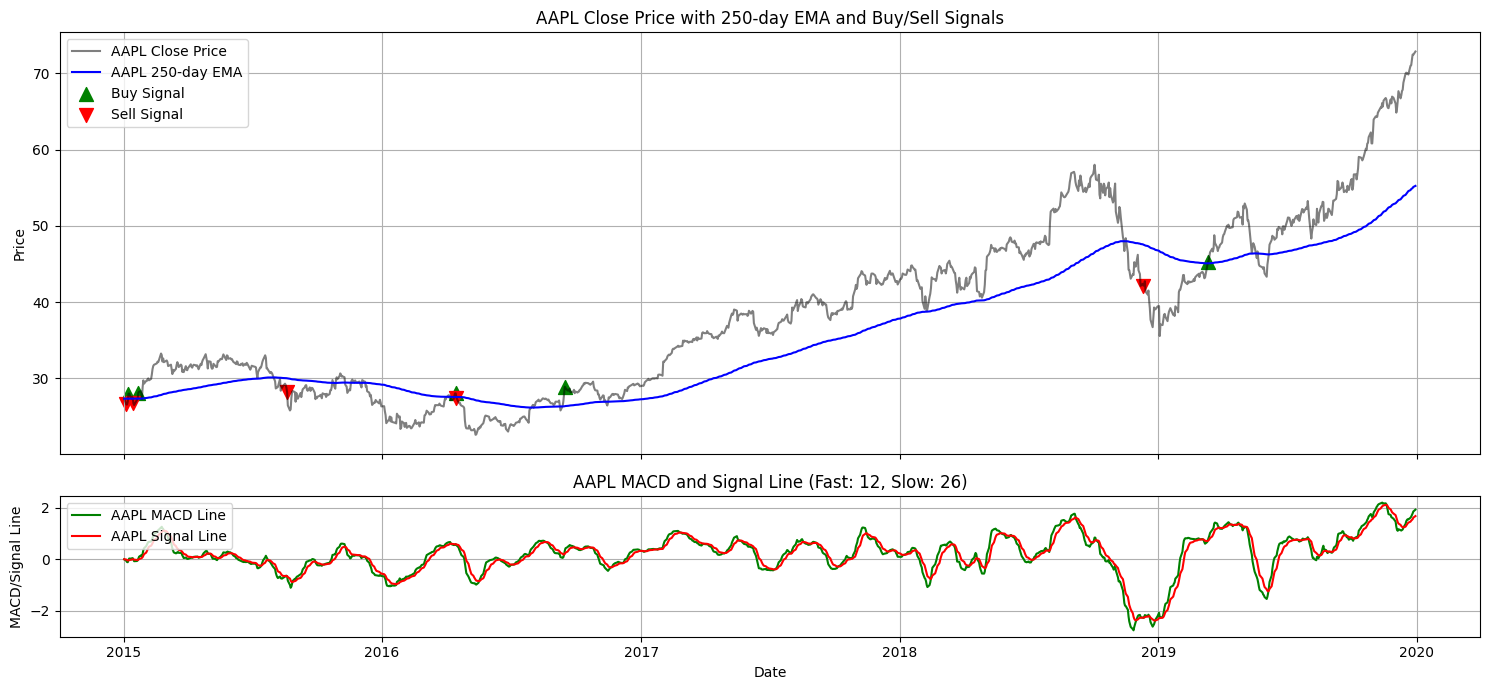

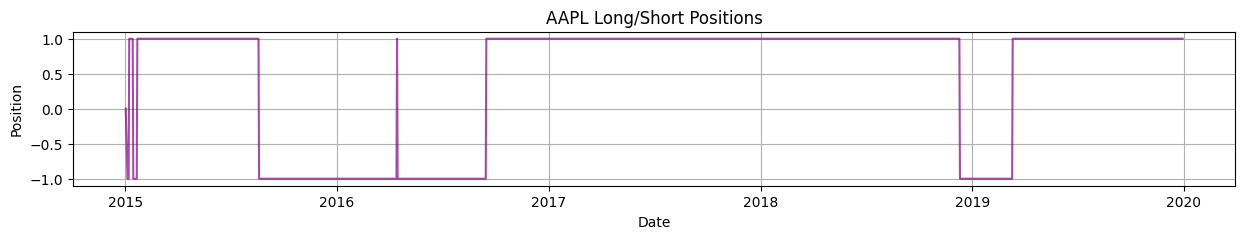

In [263]:
# For AAPL
stock = 'AAPL'
strat = tuned_stockList[stock]['strat']
ema_window = tuned_stockList[stock]['params']['ema_window']
macd_params = tuned_stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)


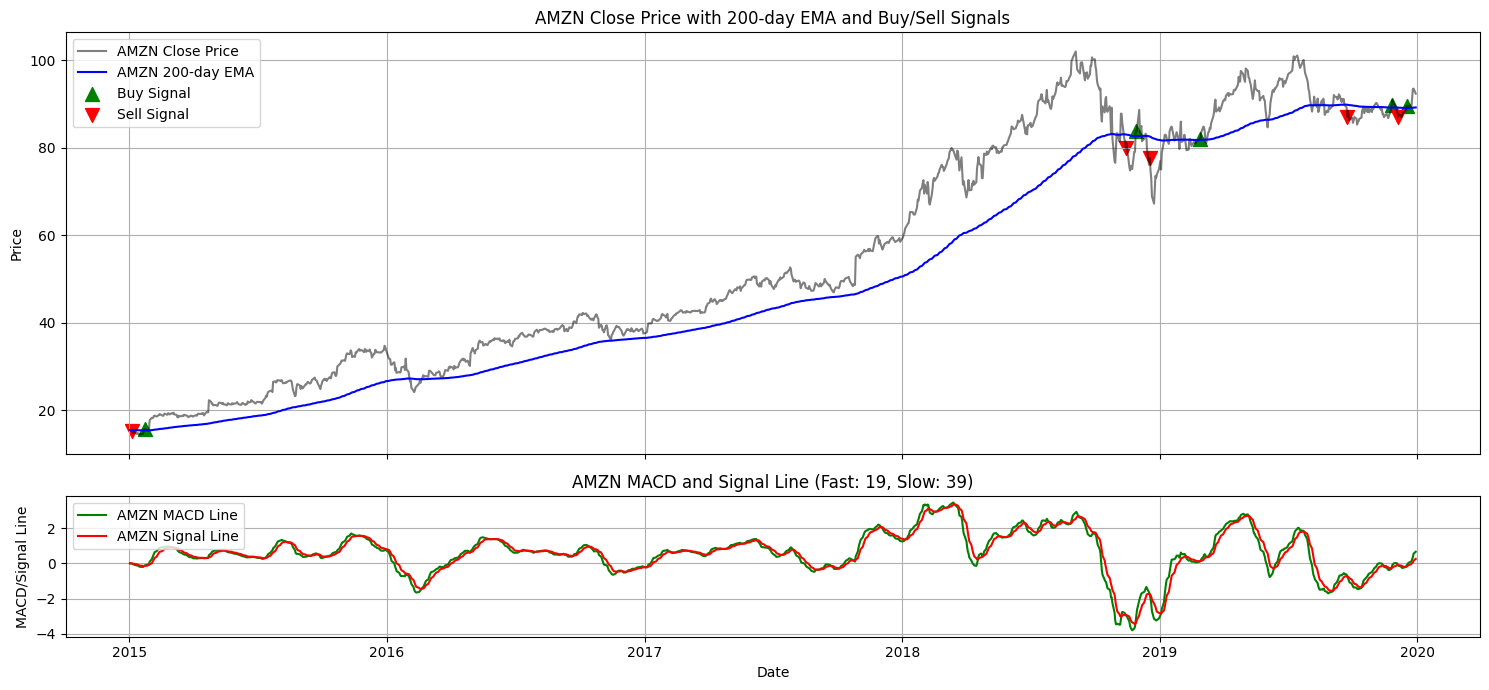

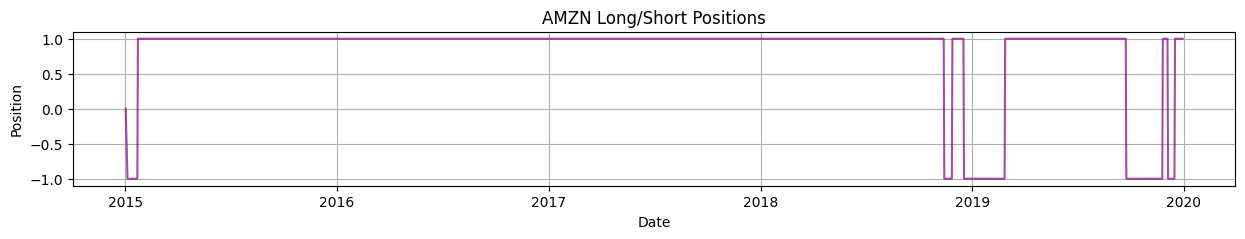

In [264]:
# For AMZN
stock = 'AMZN'
strat = tuned_stockList[stock]['strat']
ema_window = tuned_stockList[stock]['params']['ema_window']
macd_params = tuned_stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

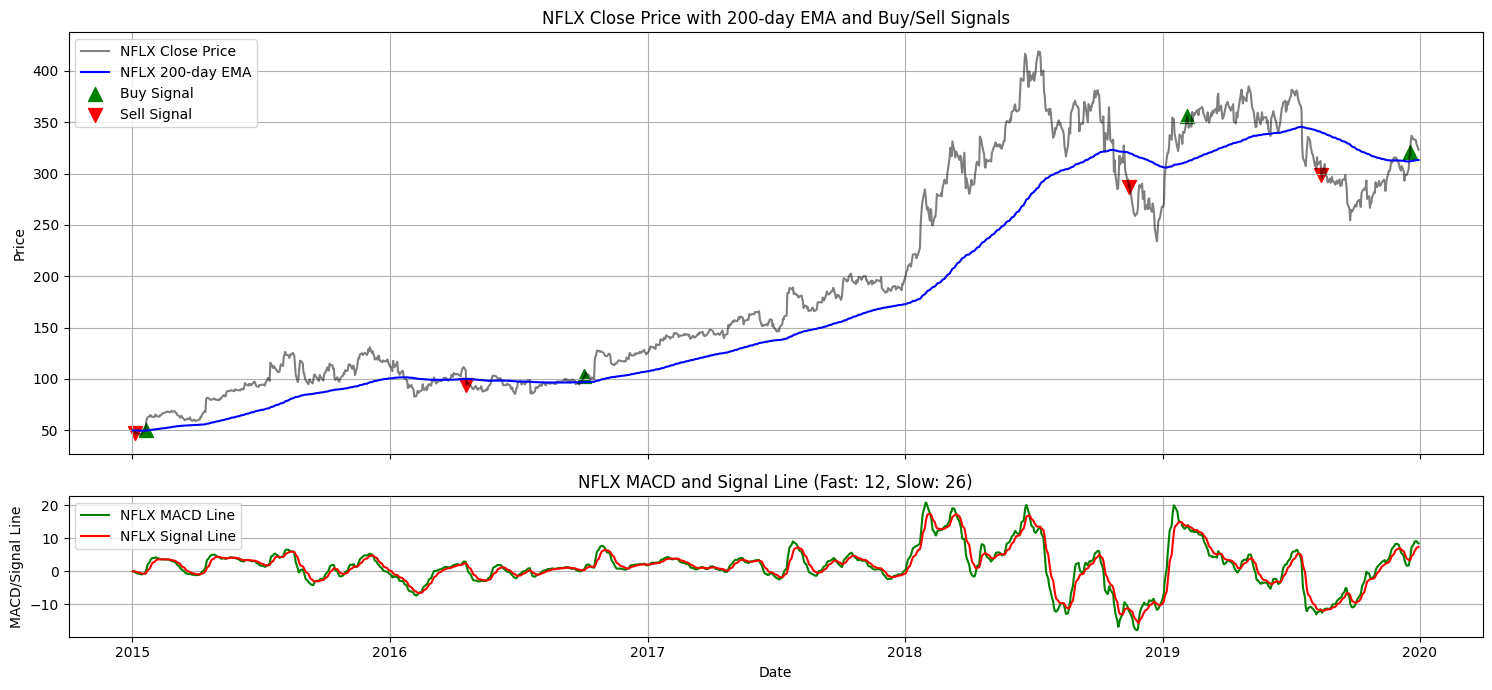

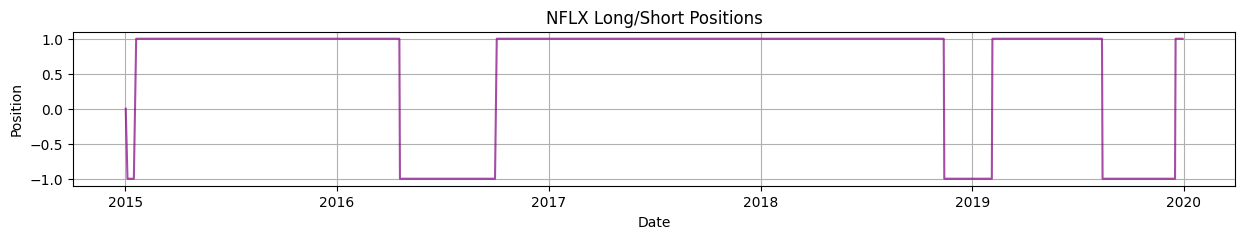

In [265]:
# For NFLX
stock = 'NFLX'
strat = tuned_stockList[stock]['strat']
ema_window = tuned_stockList[stock]['params']['ema_window']
macd_params = tuned_stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

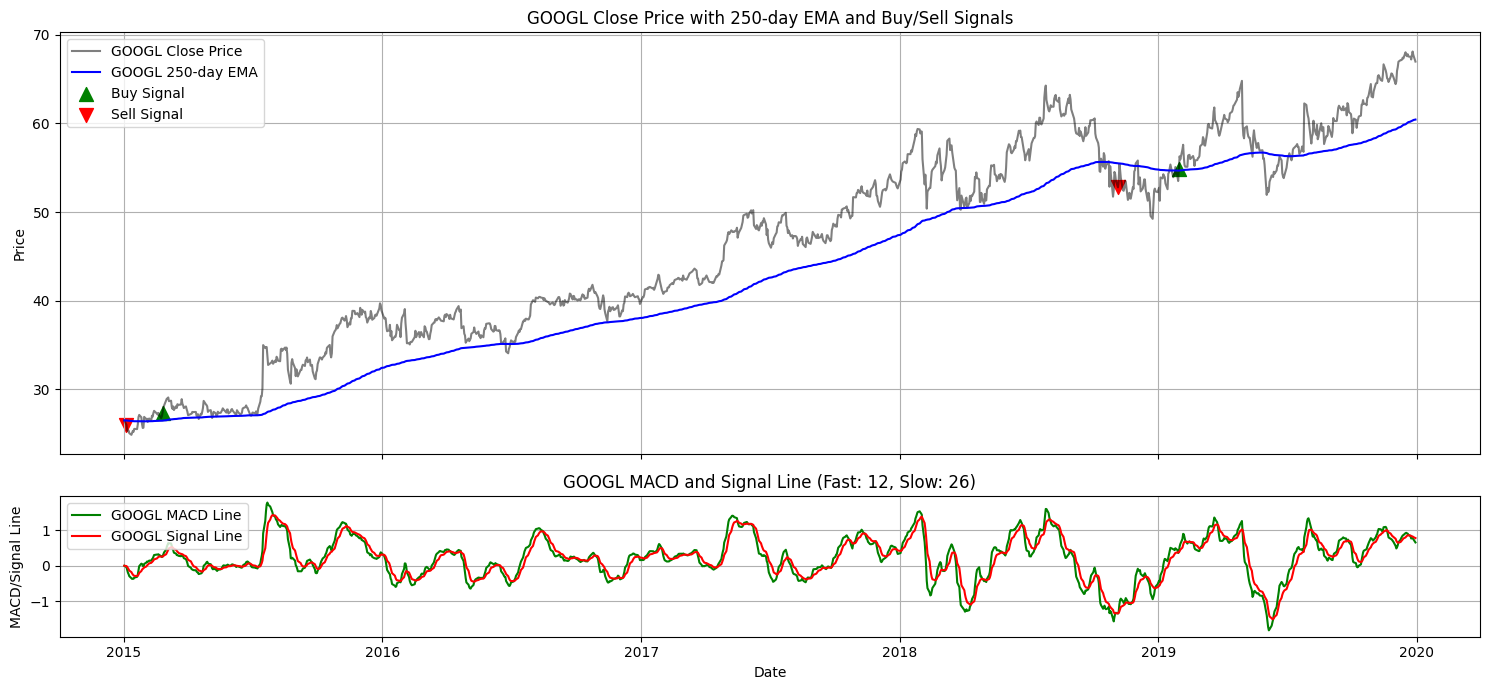

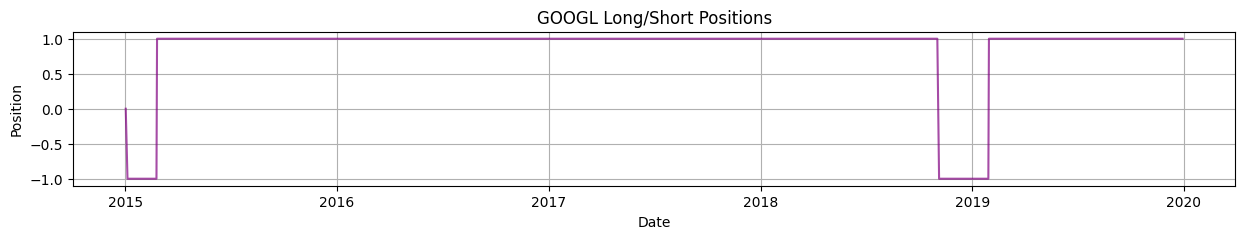

In [266]:
# For GOOGL
stock = 'GOOGL'
strat = tuned_stockList[stock]['strat']
ema_window = tuned_stockList[stock]['params']['ema_window']
macd_params = tuned_stockList[stock]['params']['macd_params']
macd_fast, macd_slow, macd_signal = macd_params

visualize_signals(stock, strat, ema_window, macd_fast, macd_slow)
plot_long_short_pos(stock, strat)

In [267]:
# Call the function to calculate log returns for each stock
tuned_stockList = calculate_log_returns(stocks, tuned_stockList)

# Output the head of each stock's DataFrame
for stock in stocks:
    print(f"Head of {stock} DataFrame:")
    display(tuned_stockList[stock]['strat'].head())  # Display the first few rows of each stock's data


Head of META DataFrame:


META_Close   META_EMA  META_MACD  META_Signal_Line  META_Position  \
2015-01-02   78.449997  78.449997   0.000000          0.000000              0   
2015-01-05   77.190002  78.437460  -0.063000         -0.012600             -1   
2015-01-06   76.150002  78.414699  -0.168550         -0.043790             -1   
2015-01-07   76.150002  78.392165  -0.257952         -0.086622             -1   
2015-01-08   78.180000  78.390054  -0.231601         -0.115618             -1   

            META_Log_Returns  META_Strategy_Log_Returns  \
2015-01-02               NaN                        NaN   
2015-01-05         -0.016191                   0.000000   
2015-01-06         -0.013565                   0.013383   
2015-01-07          0.000000                   0.000000   
2015-01-08          0.026309                  -0.027020   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

Head of AMZN DataFrame:


AMZN_Close   AMZN_EMA  AMZN_MACD  AMZN_Signal_Line  AMZN_Position  \
2015-01-02     15.4260  15.426000   0.000000          0.000000              0   
2015-01-05     15.1095  15.422850  -0.015825         -0.003165             -1   
2015-01-06     14.7645  15.416300  -0.046526         -0.011837             -1   
2015-01-07     14.9210  15.411371  -0.064718         -0.022413             -1   
2015-01-08     15.0230  15.407507  -0.074849         -0.032900             -1   

            AMZN_Log_Returns  AMZN_Strategy_Log_Returns  \
2015-01-02               NaN                        NaN   
2015-01-05         -0.020731                   0.000000   
2015-01-06         -0.023098                   0.022577   
2015-01-07          0.010544                  -0.010656   
2015-01-08          0.006813                  -0.006859   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

Head of AAPL DataFrame:


AAPL_Close   AAPL_EMA  AAPL_MACD  AAPL_Signal_Line  AAPL_Position  \
2015-01-02   27.332500  27.332500   0.000000          0.000000              0   
2015-01-05   26.562500  27.326365  -0.061425         -0.012285             -1   
2015-01-06   26.565001  27.320298  -0.108650         -0.031558             -1   
2015-01-07   26.937500  27.317248  -0.114696         -0.048186             -1   
2015-01-08   27.972500  27.322469  -0.035562         -0.045661              1   

            AAPL_Log_Returns  AAPL_Strategy_Log_Returns  \
2015-01-02               NaN                        NaN   
2015-01-05         -0.028576                   0.000000   
2015-01-06          0.000094                  -0.000094   
2015-01-07          0.013925                  -0.014121   
2015-01-08          0.037703                  -0.039180   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

Head of NFLX DataFrame:


NFLX_Close   NFLX_EMA  NFLX_MACD  NFLX_Signal_Line  NFLX_Position  \
2015-01-02   49.848572  49.848572   0.000000          0.000000              0   
2015-01-05   47.311428  49.823327  -0.202393         -0.040479             -1   
2015-01-06   46.501431  49.790273  -0.423272         -0.117037             -1   
2015-01-07   46.742859  49.759950  -0.572243         -0.208078             -1   
2015-01-08   47.779999  49.740249  -0.599701         -0.286403             -1   

            NFLX_Log_Returns  NFLX_Strategy_Log_Returns  \
2015-01-02               NaN                        NaN   
2015-01-05         -0.052238                   0.000000   
2015-01-06         -0.017269                   0.016976   
2015-01-07          0.005178                  -0.005205   
2015-01-08          0.021946                  -0.022438   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

Head of GOOGL DataFrame:


GOOGL_Close  GOOGL_EMA  GOOGL_MACD  GOOGL_Signal_Line  \
2015-01-02    26.477501  26.477501    0.000000           0.000000   
2015-01-05    25.973000  26.473481   -0.040245          -0.008049   
2015-01-06    25.332001  26.464386   -0.122451          -0.030929   
2015-01-07    25.257500  26.454769   -0.191406          -0.063025   
2015-01-08    25.345501  26.445930   -0.236228          -0.097665   

            GOOGL_Position  GOOGL_Log_Returns  GOOGL_Strategy_Log_Returns  \
2015-01-02               0                NaN                         NaN   
2015-01-05              -1          -0.019238                    0.000000   
2015-01-06              -1          -0.024989                    0.024380   
2015-01-07              -1          -0.002945                    0.002937   
2015-01-08              -1           0.003478                   -0.003490   

            Benchmark_Log_Returns  Equal_Weighted_Strategy_Log_Returns  
2015-01-02                    NaN                                  NaN  
2015-01-05              -0.027310                             0.000000  
2015-01-06              -0.015725                             0.015482  
2015-01-07               0.005360                            -0.005389  
2015-01-08               0.019330                            -0.019711

In [292]:
# Calculate and print performance for META
print("Gross performance/returns for META after tuning:\n")
calculate_gross_regular_returns('META', tuned_stockList['META']['strat'])

Gross performance/returns for META after tuning:

META Gross Stock Performance: 1.6056
META Strategy Performance: 1.1612
Gross Benchmark Performance: 3.0619



**Performance Analysis of META: Strategy Performance After Tuning**

After tuning, the gross performance of the META strategy improved to 1.1612, representing a 116.12% return on investment, up from the previous performance of 107.41%. This increase in strategy performance indicates a more effective alignment with the stock's movements, suggesting that the optimized parameters allowed the strategy to better capture upward price trends. The enhancement could be attributed to the adjustments made to the EMA and MACD settings, which likely enabled the strategy to respond more accurately to market dynamics, resulting in improved entry and exit points for trades compared to the pre-tuning phase.

In [293]:
# Calculate and print performance for AAPL
print("Gross performance/returns for AAPL after tuning:\n")
calculate_gross_regular_returns('AAPL', tuned_stockList['AAPL']['strat'])

Gross performance/returns for AAPL after tuning:

AAPL Gross Stock Performance: 1.6664
AAPL Strategy Performance: 0.5757
Gross Benchmark Performance: 3.0619



**Performance Analysis of AAPL: Strategy Performance After Tuning**

After tuning, the gross performance of the AAPL strategy improved to 0.5757, representing a 57.57% return on investment, up from the previous performance of 19.93%. Although the strategy's performance still lags significantly behind the impressive stock performance of 166.64%, the enhancement indicates that the adjustments made to the strategy parameters have allowed it to better align with AAPL's upward momentum. This improvement may suggest that the optimized settings have helped the strategy capture a larger portion of the stock's gains compared to before tuning, yet there remains substantial room for further refinement to fully leverage the stock's strong performance.

In [294]:
# Calculate and print performance for AMZN
print("Gross performance/returns for AMZN after tuning:\n")
calculate_gross_regular_returns('AMZN', tuned_stockList['AMZN']['strat'])

Gross performance/returns for AMZN after tuning:

AMZN Gross Stock Performance: 4.9863
AMZN Strategy Performance: 2.9126
Gross Benchmark Performance: 3.0619



**Performance Analysis of AMZN: Strategy Performance After Tuning**

After tuning, the gross performance of the AMZN strategy increased to 2.9126, representing a return of 291.26%, up from the previous performance of 257.15%. While the strategy has shown improvement, it still lags behind the impressive stock performance of 498.63%. This indicates that the adjustments made to the strategy parameters have allowed for better alignment with AMZN's price movements, enabling the strategy to capture more of the stock's gains. However, the strategy still faces challenges in fully capitalizing on rapid price increases, highlighting the need for further optimization to enhance performance relative to the underlying stock.

In [295]:
# Calculate and print performance for NFLX
print("Gross performance/returns for NFLX after tuning:\n")
calculate_gross_regular_returns('NFLX', tuned_stockList['NFLX']['strat'])

Gross performance/returns for NFLX after tuning:

NFLX Gross Stock Performance: 5.4858
NFLX Strategy Performance: 1.4969
Gross Benchmark Performance: 3.0619



**Performance Analysis of NFLX: Strategy Performance After Tuning**

Following the tuning process, the NFLX strategy performance for NFLX remains unchanged at 1.4969, indicating a strategy return of 149.69%, while the stock performance continues to impress at 5.4858, reflecting a return of 548.58%. Notably, the tuned parameters were identical to those originally used, resulting in no improvement in strategy performance. This persistence suggests that the strategy still struggles to align with the stock's upward momentum, highlighting that the chosen indicators may not effectively capture the dynamics of NFLX's rapid price movements, leading to missed critical buy signals during significant appreciation periods.

In [296]:
# Calculate and print performance for GOOGL
print("Gross performance/returns for GOOGL after tuning:\n")
calculate_gross_regular_returns('GOOGL', tuned_stockList['GOOGL']['strat'])

Gross performance/returns for GOOGL after tuning:

GOOGL Gross Stock Performance: 1.5299
GOOGL Strategy Performance: 1.0786
Gross Benchmark Performance: 3.0619



In [297]:
# Calculate performance for the equal-weighted strategy and print the result
print("Gross performance/returns of the equal-weighted strategy and benchmark after tuning:\n")
calculate_gross_regular_returns('Equal_Weighted_Strategy', tuned_stockList[stocks[0]]['strat'], is_equal_weighted=True)

Gross performance/returns of the equal-weighted strategy and benchmark after tuning:

Equal-Weighted Strategy Performance: 1.6578
Gross Benchmark Performance: 3.0619

The benchmark outperformed the Equal-Weighted Strategy by 1.4041


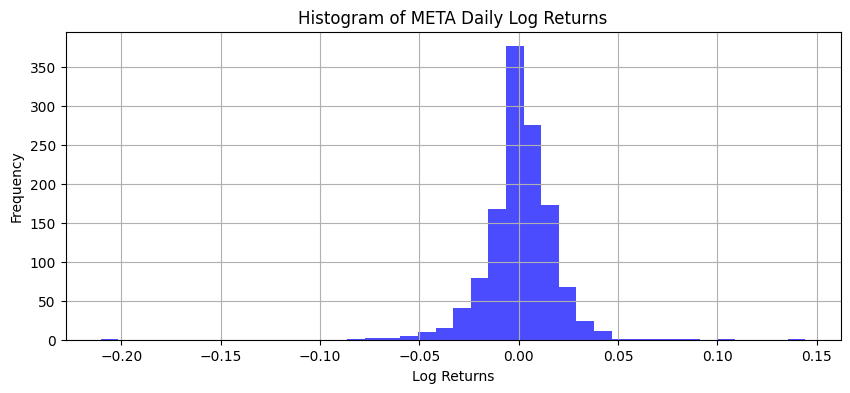

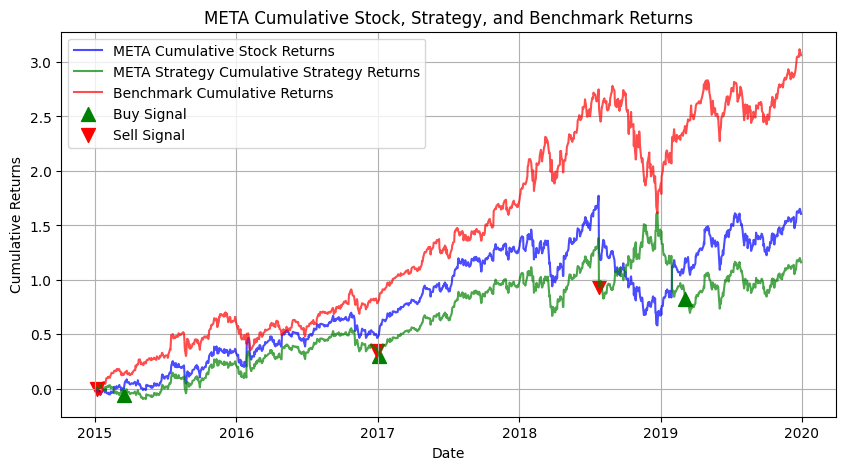

In [274]:
# Plot histogram and cumulative returns for META
plot_histogram_of_returns(tuned_stockList['META']['strat'], 'META')
plot_cumulative_returns(tuned_stockList['META']['strat'], 
                        log_return_column='META_Strategy_Log_Returns', 
                        stock='META', 
                        title='META Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='META Strategy')

**Performance Analysis of META Strategy Returns vs. Stock and Benchmark Returns after tuning**

The histogram of META's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards negative returns. This suggests that META had more losses than wins.

In the cumulative returns graph, the strategy returns (green) continued to underperformed compared to both the stock returns (blue) and the benchmark returns (red). This suggests that the strategy's buy and sell signals were not effectively timed, leading to missed opportunities to capitalize on the stock's upward momentum. However, after tuning, the green graph is now closer to the blue one, indicating an improvement in the strategy's performance. This could be attributed to the optimized parameters, which likely allowed the strategy to better capture price movements, thus enhancing its alignment with the underlying stock's trends.

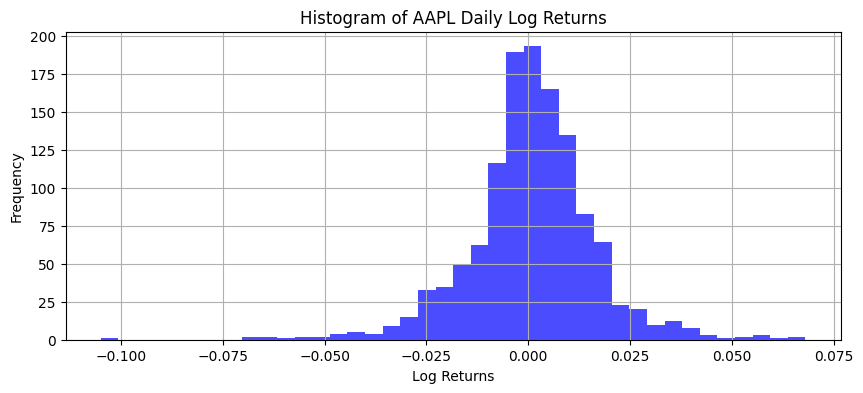

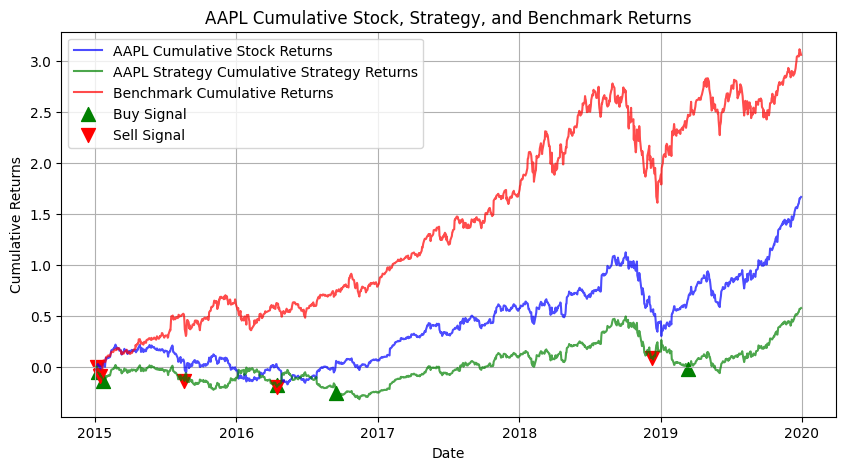

In [275]:
# Plot histogram and cumulative returns for AAPL
plot_histogram_of_returns(tuned_stockList['AAPL']['strat'], 'AAPL')
plot_cumulative_returns(tuned_stockList['AAPL']['strat'], 
                        log_return_column='AAPL_Strategy_Log_Returns', 
                        stock='AAPL', 
                        title='AAPL Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='AAPL Strategy')

**Performance Analysis of AAPL Strategy Returns vs. Stock and Benchmark Returns after tuning**

The histogram of AAPL's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards positive returns. This suggests that AAPL had more wins although they seem to have been small wins.

The cumulative returns graph indicates that the strategy returns (green) for AAPL continued to underperformed relative to both the stock returns (blue) and the benchmark returns (red). The buy and sell signals on the strategy's graph suggest that while the strategy attempted to capitalize on upward movements in the stock price, the execution appeared to be poorly timed, leading to missed opportunities during significant price increases. However, after tuning, the green graph is now closer to the blue one especially from mid-2016, indicating an improvement in the strategy's performance. This could be attributed to the optimized parameters, which likely allowed the strategy to better capture price movements, thus enhancing its alignment with the underlying stock's trends.

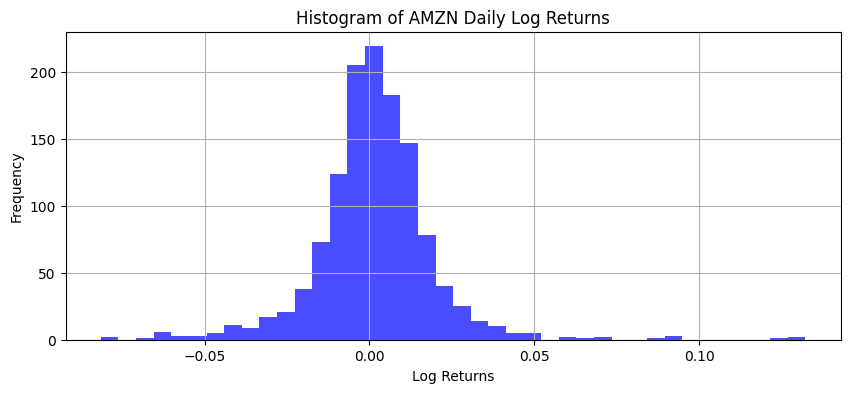

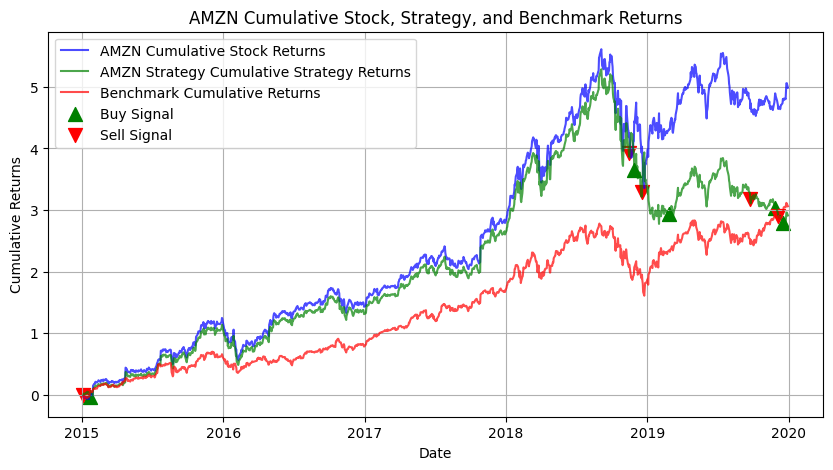

In [276]:
# Plot histogram and cumulative returns for AMZN
plot_histogram_of_returns(tuned_stockList['AMZN']['strat'], 'AMZN')
plot_cumulative_returns(tuned_stockList['AMZN']['strat'], 
                        log_return_column='AMZN_Strategy_Log_Returns', 
                        stock='AMZN', 
                        title='AMZN Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='AMZN Strategy')

**Performance Analysis of AMZN Strategy Returns vs. Stock and Benchmark Returns after tuning**

The histogram of AMZN's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards positive returns. This suggests that AMZN had more wins but small wins with certain outliers who made large wins.

The cumulative returns graph indicates that the strategy returns (green) significantly underperformed compared to the stock returns (blue), particularly during periods of upward momentum. This suggests that the strategy may not effectively capture gains from price increases, as evidenced by the delayed buy signals that coincide with the stock's upward trajectory. In fact, the tuned strategy actually underperforms more from 2015 to 2018 in which the strategy returns are being much lower than the stock returns as reflected by the larger deviation between them. However its performance in 2019 was much better this time (although it still underperformed) which gave rise to a better overall performance.

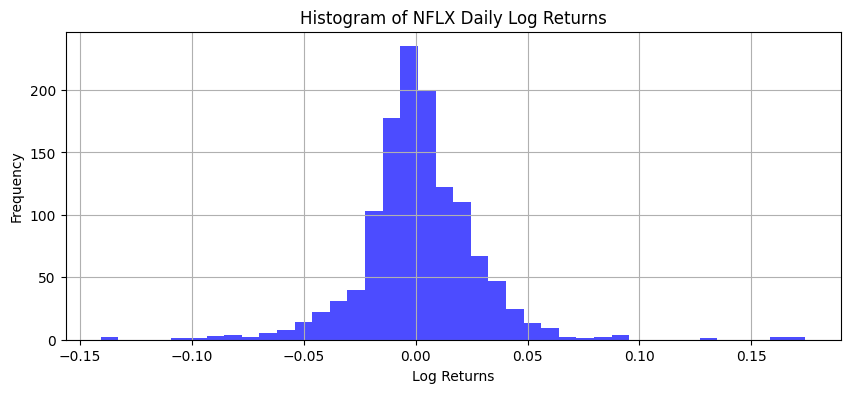

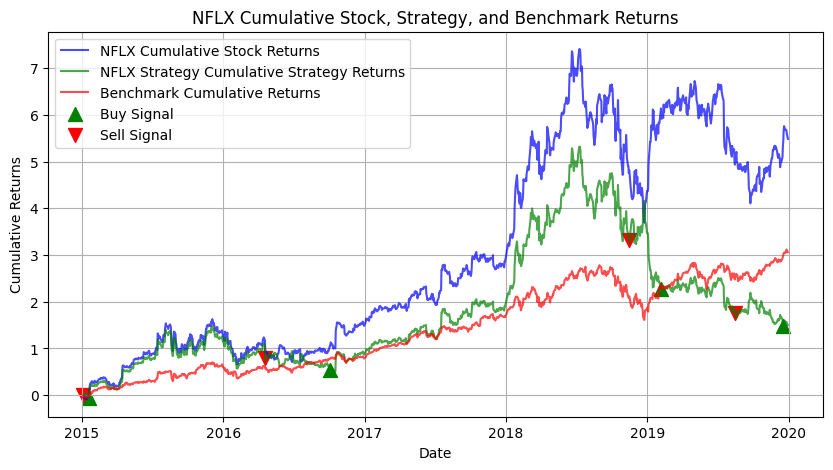

In [277]:
# Plot histogram and cumulative returns for NFLX
plot_histogram_of_returns(tuned_stockList['NFLX']['strat'], 'NFLX')
plot_cumulative_returns(tuned_stockList['NFLX']['strat'], 
                        log_return_column='NFLX_Strategy_Log_Returns', 
                        stock='NFLX', 
                        title='NFLX Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='NFLX Strategy')

**Performance Analysis of NFLX Strategy Returns vs. Stock and Benchmark Returns after tuning**

The histogram of NFLX's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards negative returns. This suggests that NFLX had more losses but small losses.

Since the best parameters for NFLX are the same as the original ones used initially, the performance of the strategy has no change. The cumulative returns graph illustrates that the strategy returns (green) for NFLX underperformed significantly compared to the stock returns (blue), particularly during upward price movements. The buy signals indicated by the green markers were generated after the stock had already begun to rise, suggesting a lag in the strategy's response, which led to missed profit opportunities. Conversely, the strategy's performance appears to have been further hampered by sell signals that occurred during periods of price recovery, indicating a potential flaw in timing that negatively impacted overall returns.


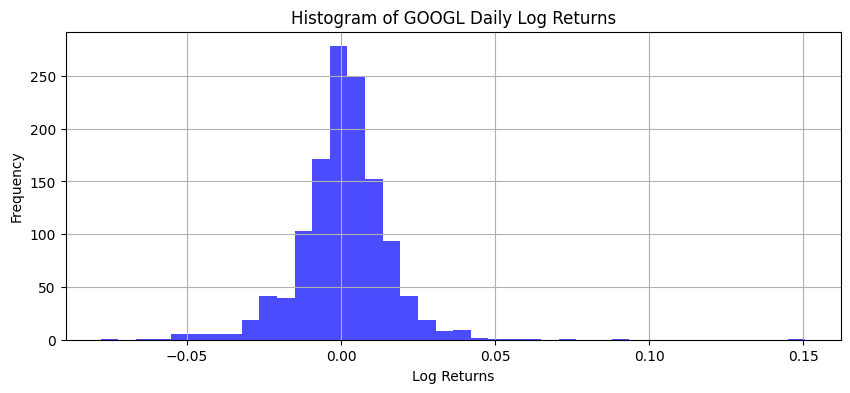

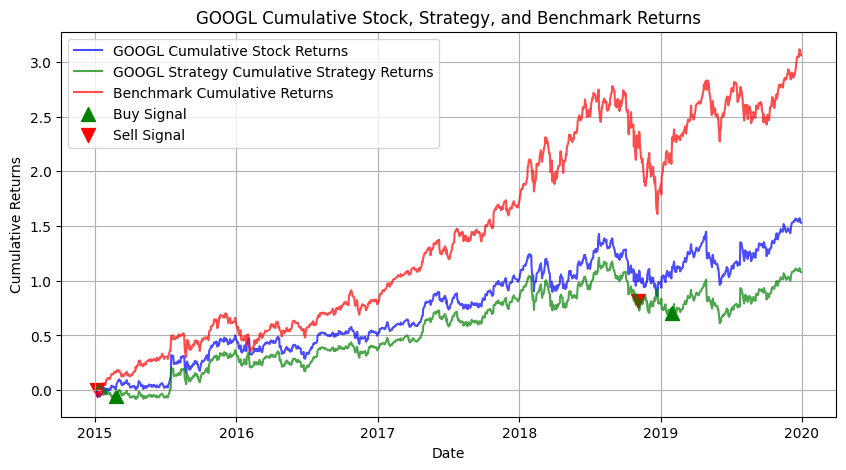

In [278]:
# Plot histogram and cumulative returns for GOOGL
plot_histogram_of_returns(tuned_stockList['GOOGL']['strat'], 'GOOGL')
plot_cumulative_returns(tuned_stockList['GOOGL']['strat'], 
                        log_return_column='GOOGL_Strategy_Log_Returns', 
                        stock='GOOGL', 
                        title='GOOGL Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='GOOGL Strategy')

**Performance Analysis of GOOGL Strategy Returns vs. Stock and Benchmark Returns after tuning**

The histogram of GOOGL's daily log returns shows that the majority of returns are clustered around zero, with a somewhat equal distribution between negative and postive returns. This suggests that GOOGL had an approximately equal number of losses and wins although the losses seem to have been larger losses compared to the win which seem to be smaller wins.

The cumulative returns graph indicates that the strategy returns (green) for GOOGL significantly lag behind both the stock returns (blue) and the benchmark returns (red). The buy and sell signals plotted on the strategy returns graph suggest that the strategy still did not effectively capitalize on upward trends. However, after tuning, the green graph is now closer to the blue one, indicating an improvement in the strategy's performance. This could be attributed to the optimized parameters, which likely allowed the strategy to better capture price movements, thus enhancing its alignment with the underlying stock's trends.

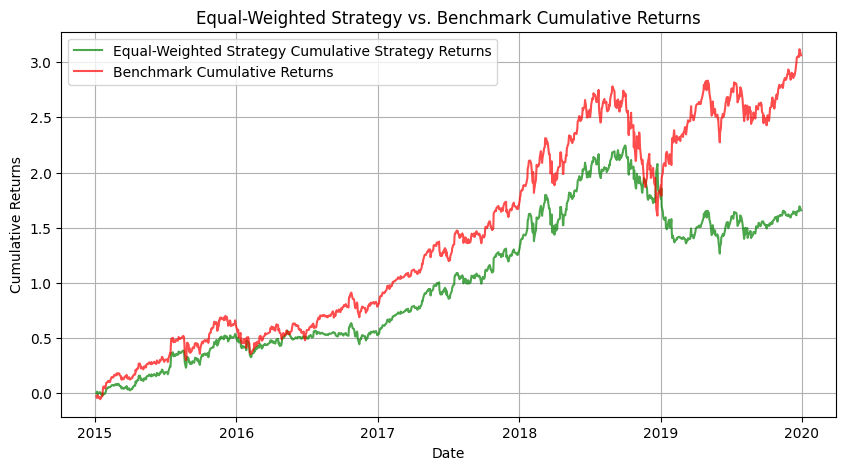

In [279]:
# Similarly, plot the cumulative returns of equal-weighted strategy consisting of our 5 individual stock strategies
plot_cumulative_returns(tuned_stockList[stocks[0]]['strat'], 
                        log_return_column='Equal_Weighted_Strategy_Log_Returns', 
                        title='Equal-Weighted Strategy vs. Benchmark Cumulative Returns', 
                        label='Equal-Weighted Strategy')

**Performance Analysis of Equal-Weighted Strategy Returns vs. Benchmark Returns after tuning**

The cumulative returns graph reveals that the equal-weighted strategy (green) continues to consistently underperformed compared to the benchmark returns (red), indicating that the strategy did not effectively capture market gains. This disparity suggests that the strategy might be overly reliant on the performance of individual stocks, failing to capitalize on collective upward trends observed in the benchmark. However, after tuning, the equal weighted strategy retuens is now closer to the benchmark returns with less deviation, indicating an improvement in the strategy's performance. This could be attributed to the optimized parameters, which likely allowed the strategy to better capture price movements, thus enhancing its alignment with the underlying stocks' trends.

In [300]:
#  for META
calculate_performance_metrics(tuned_stockList['META']['strat'], 
                              [f'META_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='META Strategy')


Performance Summary for META Strategy vs. Benchmark:

Annualized Regular Returns:
META Strategy Strategy: 0.1672
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
META Strategy Strategy: 0.2823
Benchmark: 0.2282

Sharpe Ratio:
META Strategy Strategy: 0.5923
Benchmark: 1.4228

Beta:
META Strategy Beta: 0.4633

Alpha:
META Strategy Alpha: 0.0243

Sortino Ratio:
META Strategy Sortino: 0.6436

Treynor Ratio:
META Strategy Treynor: 0.3337

Tracking Error:
META Strategy Tracking Error: 0.2913

Information Ratio:
META Strategy Information Ratio: -0.4346



**Performance Summary for META Strategy After Tuning**

After tuning, the META strategy's annualized return improved to 16.72%, while the Sharpe ratio increased to 0.5923. Although these enhancements reflect a better return for the risk taken, the strategy still underperformed compared to the benchmark's return of 32.47%, indicating that while adjustments have been made, there are ongoing challenges in effectively capturing the stock's growth potential.

In [281]:
#  for AAPL
calculate_performance_metrics(tuned_stockList['AAPL']['strat'], 
                              [f'AAPL_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='AAPL Strategy')


Performance Summary for AAPL Strategy vs. Benchmark:

Annualized Regular Returns:
AAPL Strategy Strategy: 0.0955
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
AAPL Strategy Strategy: 0.2487
Benchmark: 0.2282

Sharpe Ratio:
AAPL Strategy Strategy: 0.3841
Benchmark: 1.4228

Beta:
AAPL Strategy Beta: 0.1634

Alpha:
AAPL Strategy Alpha: 0.0453

Sortino Ratio:
AAPL Strategy Sortino: 0.4908

Treynor Ratio:
AAPL Strategy Treynor: 0.5583

Tracking Error:
AAPL Strategy Tracking Error: 0.3113

Information Ratio:
AAPL Strategy Information Ratio: -0.6103



**Performance Summary for AAPL Strategy After Tuning**

After tuning, the AAPL strategy's annualized return improved to 9.55%, and the Sharpe ratio increased to 0.3841, indicating a better return for the level of risk undertaken. The positive alpha of 0.0453 suggests that the strategy began to add value compared to the benchmark, although it still lags behind the benchmark's performance of 32.47%. Despite the improvements, the strategy's low overall return underscores the ongoing challenges in effectively harnessing AAPL's potential for capital appreciation.

In [282]:
#  for AMZN
calculate_performance_metrics(tuned_stockList['AMZN']['strat'], 
                              [f'AMZN_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='AMZN Strategy')



Performance Summary for AMZN Strategy vs. Benchmark:

Annualized Regular Returns:
AMZN Strategy Strategy: 0.3148
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
AMZN Strategy Strategy: 0.2929
Benchmark: 0.2282

Sharpe Ratio:
AMZN Strategy Strategy: 1.0749
Benchmark: 1.4228

Beta:
AMZN Strategy Beta: 0.7239

Alpha:
AMZN Strategy Alpha: 0.0701

Sortino Ratio:
AMZN Strategy Sortino: 1.2901

Treynor Ratio:
AMZN Strategy Treynor: 0.3781

Tracking Error:
AMZN Strategy Tracking Error: 0.2474

Information Ratio:
AMZN Strategy Information Ratio: -0.0304



**Performance Summary for AMZN Strategy After Tuning**

After tuning, the AMZN strategy's annualized return increased to 31.48%, bringing it closer to the benchmark return of 32.47%. The Sharpe ratio improved to 1.0749, indicating a better return per unit of risk, while the alpha rose to 0.0701, signifying enhanced value addition compared to the benchmark. Despite these positive changes, the strategy still faces challenges, as evidenced by a relatively high beta of 0.7239 and a slight decrease in the Treynor ratio to 0.3781, indicating a need for further refinement to better leverage AMZN's performance.

In [283]:
#  for NFLX
calculate_performance_metrics(tuned_stockList['NFLX']['strat'], 
                              [f'NFLX_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='NFLX Strategy')


Performance Summary for NFLX Strategy vs. Benchmark:

Annualized Regular Returns:
NFLX Strategy Strategy: 0.2015
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
NFLX Strategy Strategy: 0.4170
Benchmark: 0.2282

Sharpe Ratio:
NFLX Strategy Strategy: 0.4833
Benchmark: 1.4228

Beta:
NFLX Strategy Beta: 0.8078

Alpha:
NFLX Strategy Alpha: -0.0436

Sortino Ratio:
NFLX Strategy Sortino: 0.6610

Treynor Ratio:
NFLX Strategy Treynor: 0.2273

Tracking Error:
NFLX Strategy Tracking Error: 0.3714

Information Ratio:
NFLX Strategy Information Ratio: -0.2629



**Performance Summary for NFLX Strategy After Tuning**

After tuning, the NFLX strategy maintained its annualized return at 20.15%, with no change in performance metrics since the parameters remained the same. The Sharpe ratio remained at 0.4833, indicating that the strategy still did not effectively reward risk relative to the benchmark's performance. The beta of 0.8078 suggests moderate sensitivity to market movements, while the continued negative alpha of -0.0436 signals persistent underperformance against the benchmark, implying that despite attempts at optimization, the strategy's effectiveness in capitalizing on NFLX's growth remained limited.

In [284]:
#  for GOOGL
calculate_performance_metrics(tuned_stockList['GOOGL']['strat'], 
                              [f'GOOGL_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='GOOGL Strategy')


Performance Summary for GOOGL Strategy vs. Benchmark:

Annualized Regular Returns:
GOOGL Strategy Strategy: 0.1581
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
GOOGL Strategy Strategy: 0.2378
Benchmark: 0.2282

Sharpe Ratio:
GOOGL Strategy Strategy: 0.6649
Benchmark: 1.4228

Beta:
GOOGL Strategy Beta: 0.5789

Alpha:
GOOGL Strategy Alpha: -0.0160

Sortino Ratio:
GOOGL Strategy Sortino: 0.8379

Treynor Ratio:
GOOGL Strategy Treynor: 0.2536

Tracking Error:
GOOGL Strategy Tracking Error: 0.2184

Information Ratio:
GOOGL Strategy Information Ratio: -0.6154



**Performance Summary for GOOGL Strategy After Tuning**

After tuning, the GOOGL strategy's annualized return improved to 15.81%, although it still fell short of the benchmark's return of 32.47%. The Sharpe ratio increased to 0.6649, indicating an enhanced risk-return profile compared to the pre-tuning results, yet it still lags behind the benchmark's ratio. Despite the improvement, the alpha remained negative at -0.0160, suggesting that while the strategy became more effective post-tuning, it still failed to fully capitalize on GOOGL's potential growth.

In [285]:
#  for the equal-weighted strategy
print("Perfomance metrics for Equal-Weighted Strategy after tuning:\n")
calculate_performance_metrics(tuned_stockList[stocks[0]]['strat'],  # You can use any stock's DataFrame (e.g., META)
                              ['Equal_Weighted_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name="Equal-Weighted Strategy")



Performance Summary for Equal-Weighted Strategy vs. Benchmark:

Annualized Regular Returns:
Equal-Weighted Strategy Strategy: 0.2167
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
Equal-Weighted Strategy Strategy: 0.1964
Benchmark: 0.2282

Sharpe Ratio:
Equal-Weighted Strategy Strategy: 1.1034
Benchmark: 1.4228

Beta:
Equal-Weighted Strategy Beta: 0.5483

Alpha:
Equal-Weighted Strategy Alpha: 0.0419

Sortino Ratio:
Equal-Weighted Strategy Sortino: 1.2593

Treynor Ratio:
Equal-Weighted Strategy Treynor: 0.3577

Tracking Error:
Equal-Weighted Strategy Tracking Error: 0.1834

Information Ratio:
Equal-Weighted Strategy Information Ratio: -0.4640



**Performance Summary for Equal-Weighted Strategy After Tuning**

After tuning, the equal-weighted strategy's annualized return improved to 21.67%, although it still fell short of the benchmark's return of 32.47%. The Sharpe ratio increased to 1.1034, indicating a better risk-adjusted return, while the positive alpha of 0.0419 suggests that the strategy began to capture some excess returns relative to its risk profile. Overall, these improvements indicate that the tuning process enhanced the strategy's performance metrics, although it continued to trail behind the benchmark.

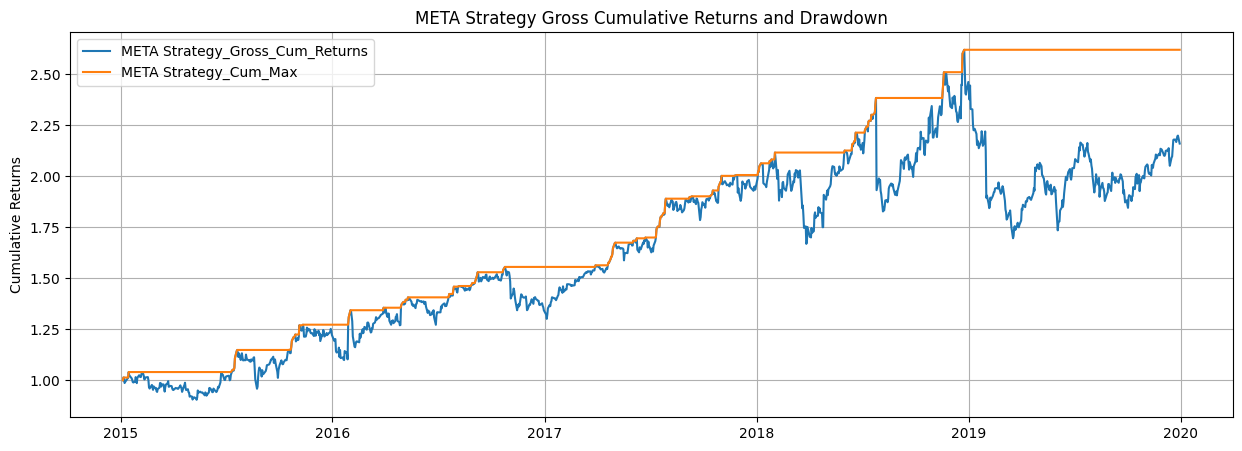

Max Drawdown for META Strategy: 0.9246
Max Drawdown Period for META Strategy: 179 days 00:00:00


In [286]:
# Calculate and plot drawdown for META Strategy
calculate_and_plot_drawdown(tuned_stockList['META']['strat'], 
                            log_return_column='META_Strategy_Log_Returns', 
                            stock='META', 
                            strategy_name='META Strategy')

**Max Drawdown Summary for META After Tuning**

Following the tuning process, the maximum drawdown increased to 0.9246, representing a deeper peak-to-trough decline of about 92.46% over 179 days. While the duration of the drawdown slightly decreased, the greater drawdown indicates that the adjustments made did not improve the strategy's performance in downturns, resulting in increased potential losses. This suggests that the tuned parameters may not have effectively aligned with market conditions, leading to a higher risk profile for the strategy.

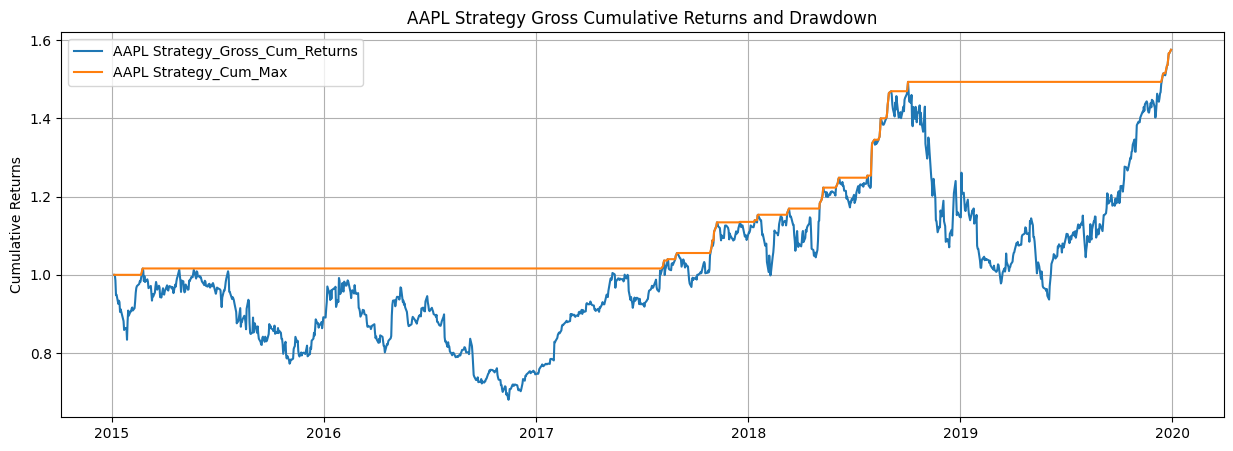

Max Drawdown for AAPL Strategy: 0.5569
Max Drawdown Period for AAPL Strategy: 896 days 00:00:00


In [287]:
# Calculate and plot drawdown for AAPL Strategy
calculate_and_plot_drawdown(tuned_stockList['AAPL']['strat'], 
                            log_return_column='AAPL_Strategy_Log_Returns', 
                            stock='AAPL', 
                            strategy_name='AAPL Strategy')


**Max Drawdown Summary for AAPL After Tuning**

After tuning, the maximum drawdown increased to 0.5569, representing a deeper peak-to-trough decline of about 55.69% over a shorter duration of 896 days. The increase in drawdown indicates that while the duration of the decline decreased, the strategy now experiences greater potential losses during adverse market conditions. This suggests that the tuning adjustments may not have effectively improved the strategy's resilience, resulting in a higher risk profile compared to its performance before tuning.

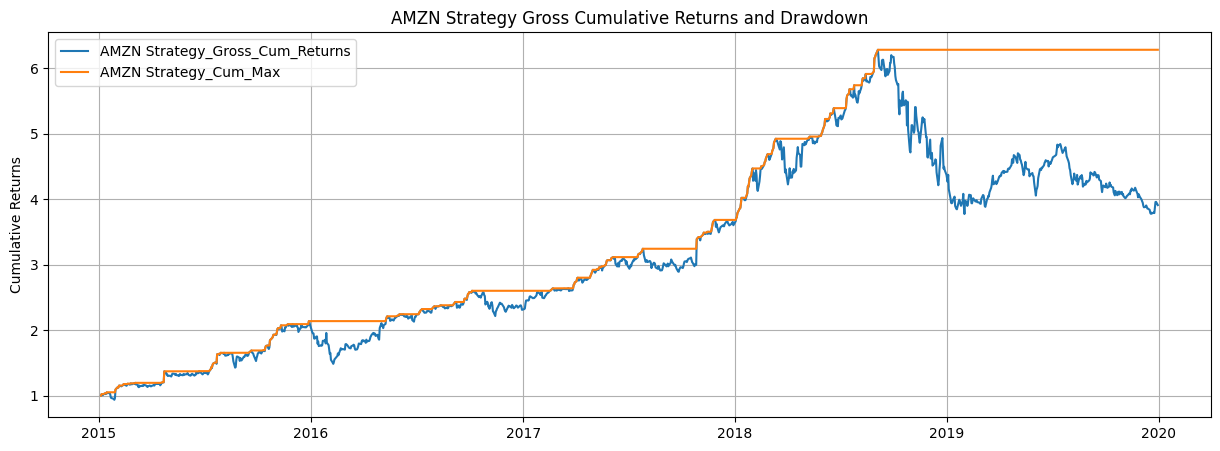

Max Drawdown for AMZN Strategy: 2.5104
Max Drawdown Period for AMZN Strategy: 135 days 00:00:00


In [288]:
# Calculate and plot drawdown for AMZN Strategy
calculate_and_plot_drawdown(tuned_stockList['AMZN']['strat'], 
                            log_return_column='AMZN_Strategy_Log_Returns', 
                            stock='AMZN', 
                            strategy_name='AMZN Strategy')


**Max Drawdown Summary for AMZN After Tuning**

After tuning, the maximum drawdown improved to 2.5104, reflecting a reduced peak-to-trough decline of about 251.04% over the same period of 135 days. This decrease in drawdown suggests that the tuning adjustments made the strategy more resilient, leading to a lower risk exposure during market downturns, while still indicating significant potential losses that warrant careful management.

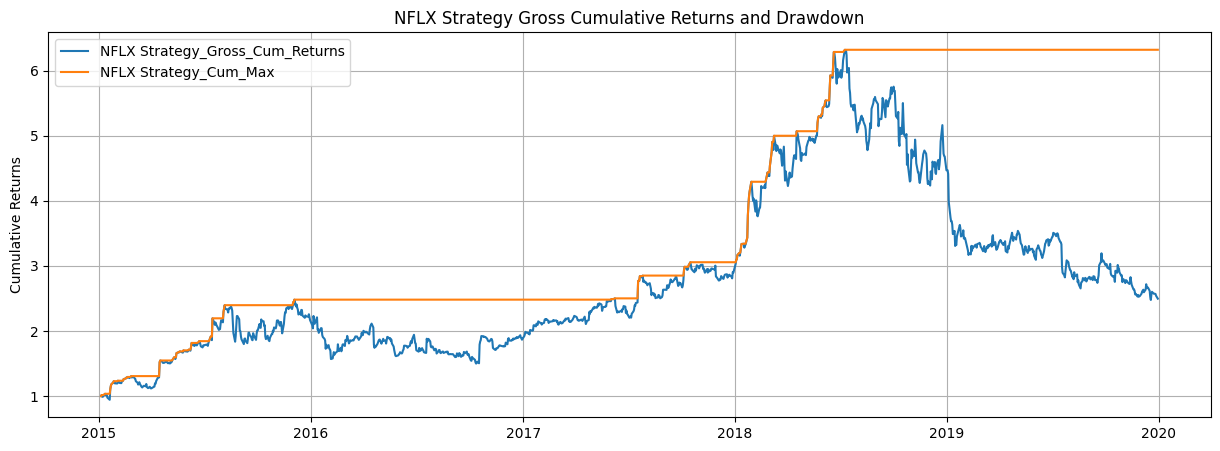

Max Drawdown for NFLX Strategy: 3.8406
Max Drawdown Period for NFLX Strategy: 546 days 00:00:00


In [289]:
# Calculate and plot drawdown for NFLX Strategy
calculate_and_plot_drawdown(tuned_stockList['NFLX']['strat'], 
                            log_return_column='NFLX_Strategy_Log_Returns', 
                            stock='NFLX', 
                            strategy_name='NFLX Strategy')

**Max Drawdown Summary for NFLX After Tuning**

The maximum drawdown remains at 3.8406, with the same duration of 546 days. Since the tuned parameters are unchanged from the original parameters, this stability in drawdown suggests that the strategy's risk profile has not improved, indicating a persistent challenge in effectively managing drawdowns within this strategy framework.

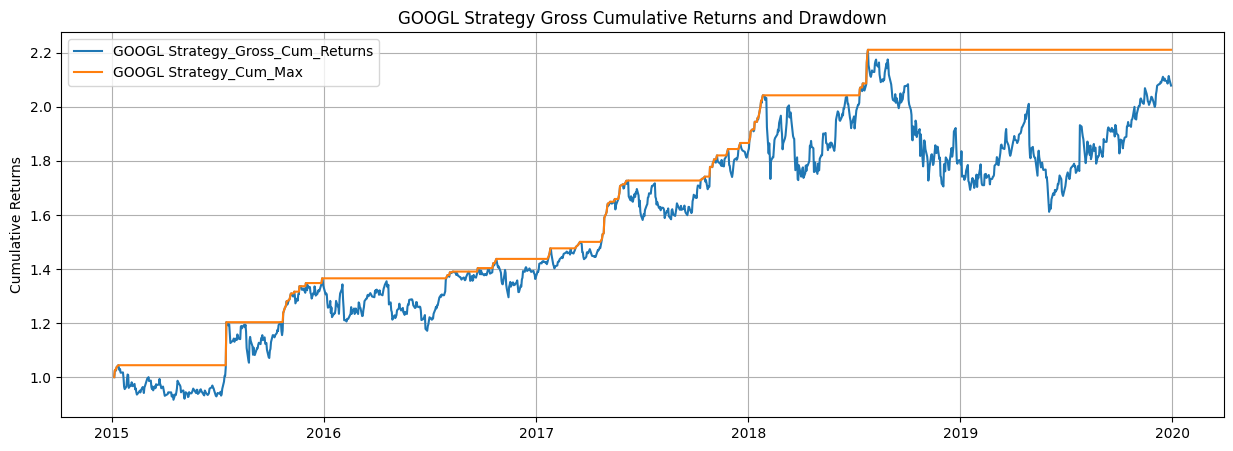

Max Drawdown for GOOGL Strategy: 0.5994
Max Drawdown Period for GOOGL Strategy: 216 days 00:00:00


In [290]:
# Calculate and plot drawdown for GOOGL Strategy
calculate_and_plot_drawdown(tuned_stockList['GOOGL']['strat'], 
                            log_return_column='GOOGL_Strategy_Log_Returns', 
                            stock='GOOGL', 
                            strategy_name='GOOGL Strategy')

**Max Drawdown Summary for GOOGL After Tuning**

The maximum drawdown increased to 0.5994, with the drawdown period remaining the same at 216 days. This increase suggests that despite the tuning efforts, the strategy has not improved in terms of risk management, resulting in a deeper decline that could indicate a need for reevaluation of the strategy's parameters or execution during adverse market conditions.

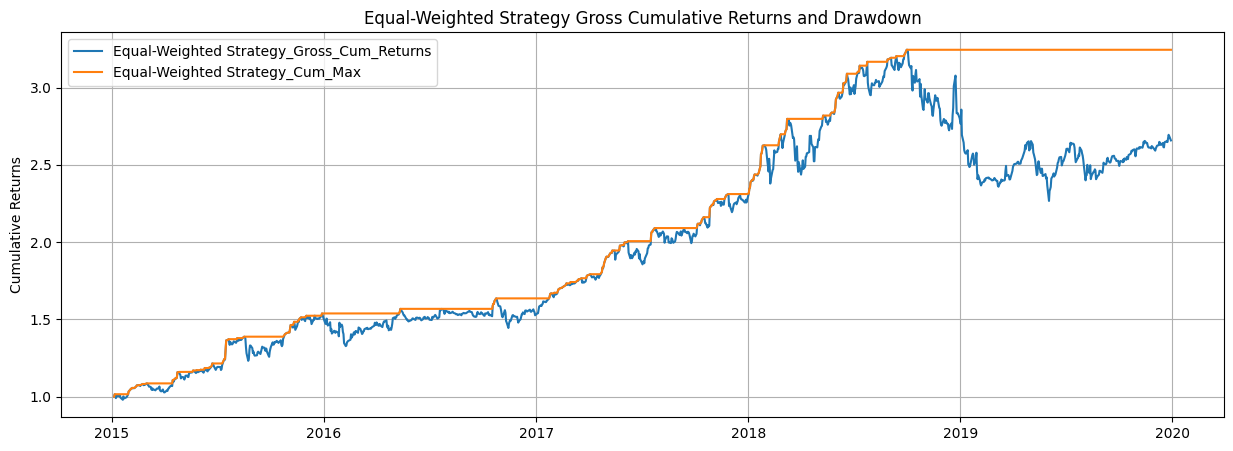

Max Drawdown for Equal-Weighted Strategy: 0.9780
Max Drawdown Period for Equal-Weighted Strategy: 159 days 00:00:00


In [291]:
# Calculate and plot drawdown for the equal-weighted strategy
calculate_and_plot_drawdown(tuned_stockList[stocks[0]]['strat'],  
                            log_return_column='Equal_Weighted_Strategy_Log_Returns', 
                            strategy_name="Equal-Weighted Strategy")

**Max Drawdown Summary for Equal-Weighted Strategy After Tuning**

After tuning, the maximum drawdown increased to 0.9780, while the drawdown period decreased to 159 days. This increase in drawdown signifies that the tuning did not enhance the strategy's risk management; in fact, it resulted in a deeper decline over a shorter duration, suggesting a need for further refinement to improve resilience against market volatility.